# Capstone project - Data wrangling and EDA
## Automated Valuation Model for HDB Properties
> Capstone project for the fulfilment of Data Science and AI certification with Institute of Data
- July 2021

In [1]:
import numpy as np
import pandas as pd
import json, datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from onemapsg import OneMapClient
import time
from tqdm import tqdm

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 7)

## Loading primary dataset

In [3]:
file_jan17_onwards = 'resale-flat-prices-jan-2017-jun-2021.csv'
df = pd.read_csv(file_jan17_onwards)

In [8]:
df.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.0  
4      265000.0

In [9]:
df.tail()

month    town  flat_type block     street_name storey_range  \
101298  2021-06  YISHUN  EXECUTIVE   359  YISHUN RING RD     07 TO 09   
101299  2021-06  YISHUN  EXECUTIVE   277    YISHUN ST 22     01 TO 03   
101300  2021-06  YISHUN  EXECUTIVE   643    YISHUN ST 61     01 TO 03   
101301  2021-06  YISHUN  EXECUTIVE   724    YISHUN ST 71     04 TO 06   
101302  2021-06  YISHUN  EXECUTIVE   828    YISHUN ST 81     04 TO 06   

        floor_area_sqm  flat_model  lease_commence_date     remaining_lease  \
101298           142.0   Apartment                 1988  66 years 02 months   
101299           152.0  Maisonette                 1985  63 years 03 months   
101300           146.0  Maisonette                 1987  65 years 04 months   
101301           142.0   Apartment                 1986  64 years 02 months   
101302           146.0  Maisonette                 1988  65 years 08 months   

        resale_price  
101298      615000.0  
101299      585000.0  
101300      600000.0  
101301      570000.0  
101302      715000.0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101303 entries, 0 to 101302
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                101303 non-null  object 
 1   town                 101303 non-null  object 
 2   flat_type            101303 non-null  object 
 3   block                101303 non-null  object 
 4   street_name          101303 non-null  object 
 5   storey_range         101303 non-null  object 
 6   floor_area_sqm       101303 non-null  float64
 7   flat_model           101303 non-null  object 
 8   lease_commence_date  101303 non-null  int64  
 9   remaining_lease      101303 non-null  object 
 10  resale_price         101303 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 8.5+ MB


## Reviewing data in primary dataset

In [11]:
def data_review(df):
    print('--Dataframe shape--\n{}\n'.format(df.shape))
    print('--Dataframe features--\n{}\n'.format(df.columns.values))
    print('--Dataframe duplicates--\n{}\n'.format(df.duplicated().any()))
    print('--Dataframe dtypes--\n{}\n'.format(df.dtypes.value_counts()))
    
    desc = df.describe().apply(lambda x: x.apply('{0:.2f}'.format))
    print('--Dataframe numerical columns--\n{}\n'.format(desc))

    for col in df.select_dtypes(include=np.number).columns: 
        print(col, "column")
        print("Number of unique:", df[col].nunique())
        print(df[col].value_counts(), '\n')

    for col in df.select_dtypes(include='object').columns: 
        print(col, "column")
        print("Number of unique:", df[col].nunique())
        print(df[col].value_counts(), '\n')
        
    return 0

In [12]:
data_review(df)

--Dataframe shape--
(101303, 11)

--Dataframe features--
['month' 'town' 'flat_type' 'block' 'street_name' 'storey_range'
 'floor_area_sqm' 'flat_model' 'lease_commence_date' 'remaining_lease'
 'resale_price']

--Dataframe duplicates--
True

--Dataframe dtypes--
object     8
float64    2
int64      1
dtype: int64

--Dataframe numerical columns--
      floor_area_sqm lease_commence_date resale_price
count      101303.00           101303.00    101303.00
mean           97.79             1994.72    450141.40
std            24.20               13.23    156371.68
min            31.00             1966.00    140000.00
25%            82.00             1985.00    338000.00
50%            95.00             1995.00    420000.00
75%           113.00             2004.00    530000.00
max           249.00             2019.00   1268000.00

floor_area_sqm column
Number of unique: 166
67.0     6374
92.0     6191
93.0     5701
110.0    5101
104.0    3646
         ... 
237.0       1
183.0       1
37.0     

0

In [15]:
df[df.duplicated()]

month           town flat_type block          street_name  \
243    2017-01    BUKIT MERAH    4 ROOM   106       HENDERSON CRES   
305    2017-01   CENTRAL AREA    3 ROOM   271             QUEEN ST   
510    2017-01    JURONG EAST    4 ROOM   265          TOH GUAN RD   
591    2017-01    JURONG WEST    4 ROOM  337A         TAH CHING RD   
672    2017-01      PASIR RIS    4 ROOM   753      PASIR RIS ST 71   
...        ...            ...       ...   ...                  ...   
97568  2021-05  CHOA CHU KANG    5 ROOM  815C  CHOA CHU KANG AVE 7   
98469  2021-05       SENGKANG    4 ROOM  432A    SENGKANG WEST WAY   
98927  2021-05         YISHUN    4 ROOM  348C        YISHUN AVE 11   
99654  2021-06       CLEMENTI    3 ROOM   602   CLEMENTI WEST ST 1   
99694  2021-06        GEYLANG    3 ROOM    99        ALJUNIED CRES   

      storey_range  floor_area_sqm      flat_model  lease_commence_date  \
243       07 TO 09            81.0        Improved                 1975   
305       16 TO 18            68.0        Improved                 1979   
510       04 TO 06           101.0         Model A                 1998   
591       19 TO 21            92.0         Model A                 2010   
672       01 TO 03           105.0         Model A                 1996   
...            ...             ...             ...                  ...   
97568     10 TO 12           113.0        Improved                 2017   
98469     16 TO 18            93.0         Model A                 2014   
98927     10 TO 12            92.0            DBSS                 2013   
99654     01 TO 03            67.0  New Generation                 1979   
99694     04 TO 06            67.0  New Generation                 1978   

          remaining_lease  resale_price  
243              57 years      470000.0  
305    61 years 02 months      470000.0  
510    80 years 09 months      470000.0  
591    92 years 03 months      470000.0  
672    78 years 10 months      368000.0  
...                   ...           ...  
97568  94 years 11 months      590000.0  
98469  92 years 06 months      465000.0  
98927  91 years 05 months      618000.0  
99654  57 years 06 months      300000.0  
99694  55 years 08 months      280000.0  

[229 rows x 11 columns]

There appears to be duplicated values. We will randomly pick a few to ascertain that they are indeed duplicates

In [16]:
df[(df.block.values == '271') & (df.town.values == 'CENTRAL AREA')]

month          town flat_type block street_name storey_range  \
304    2017-01  CENTRAL AREA    3 ROOM   271    QUEEN ST     16 TO 18   
305    2017-01  CENTRAL AREA    3 ROOM   271    QUEEN ST     16 TO 18   
13883  2017-09  CENTRAL AREA    5 ROOM   271    QUEEN ST     19 TO 21   
15612  2017-10  CENTRAL AREA    3 ROOM   271    QUEEN ST     04 TO 06   
15616  2017-10  CENTRAL AREA    3 ROOM   271    QUEEN ST     04 TO 06   
20767  2018-01  CENTRAL AREA    3 ROOM   271    QUEEN ST     04 TO 06   
30795  2018-07  CENTRAL AREA    3 ROOM   271    QUEEN ST     16 TO 18   
39217  2018-11  CENTRAL AREA    3 ROOM   271    QUEEN ST     19 TO 21   
50998  2019-06  CENTRAL AREA    3 ROOM   271    QUEEN ST     10 TO 12   
54987  2019-08  CENTRAL AREA    3 ROOM   271    QUEEN ST     13 TO 15   
71133  2020-06  CENTRAL AREA    3 ROOM   271    QUEEN ST     10 TO 12   
71134  2020-06  CENTRAL AREA    3 ROOM   271    QUEEN ST     10 TO 12   
78449  2020-09  CENTRAL AREA    3 ROOM   271    QUEEN ST     10 TO 12   
92774  2021-03  CENTRAL AREA    3 ROOM   271    QUEEN ST     13 TO 15   
92775  2021-03  CENTRAL AREA    3 ROOM   271    QUEEN ST     16 TO 18   
99490  2021-06  CENTRAL AREA    3 ROOM   271    QUEEN ST     13 TO 15   

       floor_area_sqm     flat_model  lease_commence_date     remaining_lease  \
304              68.0       Improved                 1979  61 years 02 months   
305              68.0       Improved                 1979  61 years 02 months   
13883           128.0  Adjoined flat                 1979  60 years 06 months   
15612            68.0       Improved                 1979  60 years 05 months   
15616            68.0       Improved                 1979  60 years 05 months   
20767            60.0       Improved                 1979  60 years 02 months   
30795            68.0       Improved                 1979  59 years 09 months   
39217            60.0       Improved                 1979  59 years 04 months   
50998            60.0       Improved                 1979  58 years 09 months   
54987            68.0       Improved                 1979  58 years 07 months   
71133            60.0       Improved                 1979  57 years 11 months   
71134            68.0       Improved                 1979  57 years 10 months   
78449            60.0       Improved                 1979  57 years 06 months   
92774            68.0       Improved                 1979   57 years 01 month   
92775            60.0       Improved                 1979   57 years 01 month   
99490            68.0       Improved                 1979  56 years 10 months   

       resale_price  
304        470000.0  
305        470000.0  
13883      860000.0  
15612      470000.0  
15616      470000.0  
20767      415000.0  
30795      500000.0  
39217      422000.0  
50998      398000.0  
54987      480000.0  
71133      405000.0  
71134      450000.0  
78449      412000.0  
92774      480888.0  
92775      440000.0  
99490      470000.0

We can't really tell if the data is indeed duplicates. HDB masks the exact unit under storey range so it could be coincidental that a pair of neighbours sold their place at the same time and same price.

## Data Understanding and Feature Engineering
Data is retrieved from https://data.gov.sg/dataset/resale-flat-prices. 

From the primary dataset, we have 101,303 observations and 11 features. These are the features retrieved from the dataset. 

1. `month` - Year and Month that the property was transacted. Can be converted to datetime and moved to index
2. `town` - name of town that property is located in
3. `flat_type` - typically the number of rooms of the property. can be converted to ordinal 
4. `block` - block number of the property
5. `street_name` - name of the street that the property is located on
5. `storey_range` - the storey that property is located on. range is provided by because of privacy reasons. can be converted to ordinal
7. `floor_area_sqm` - size of property in square meters
8. `flat_model` - model of the property
9. `lease_commence_date` - date that lease commenced
10. `remaining_lease` - properties are typically leased for 99 years. this shows the remaining lease
11. `resale_price` - the transacted price. Also the target variable that we are trying to predict


We will further look at other data sources and feature engineering for our model
1. Geospatial data
    - Distance to MRT/LRT stations (public transportation)
    - Distance to the city center
    - Distance to shopping malls
2. Mature/Non-mature estate
3. Macroconomic figures
    - New HDB supply
4. Getting CPI - Accommodation data to peg prices to today's price
4. Creating a one-month and three-month moving average by township


In [17]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [18]:
df.tail(10)

month    town  flat_type block     street_name storey_range  \
101293  2021-06  YISHUN     5 ROOM   820    YISHUN ST 81     01 TO 03   
101294  2021-06  YISHUN  EXECUTIVE  350A   YISHUN AVE 11     01 TO 03   
101295  2021-06  YISHUN  EXECUTIVE   664    YISHUN AVE 4     01 TO 03   
101296  2021-06  YISHUN  EXECUTIVE   664    YISHUN AVE 4     07 TO 09   
101297  2021-06  YISHUN  EXECUTIVE   387  YISHUN RING RD     01 TO 03   
101298  2021-06  YISHUN  EXECUTIVE   359  YISHUN RING RD     07 TO 09   
101299  2021-06  YISHUN  EXECUTIVE   277    YISHUN ST 22     01 TO 03   
101300  2021-06  YISHUN  EXECUTIVE   643    YISHUN ST 61     01 TO 03   
101301  2021-06  YISHUN  EXECUTIVE   724    YISHUN ST 71     04 TO 06   
101302  2021-06  YISHUN  EXECUTIVE   828    YISHUN ST 81     04 TO 06   

        floor_area_sqm  flat_model  lease_commence_date     remaining_lease  \
101293           121.0    Improved                 1988  66 years 03 months   
101294           154.0  Maisonette                 1988  66 years 02 months   
101295           181.0   Apartment                 1992  69 years 11 months   
101296           164.0   Apartment                 1992            70 years   
101297           146.0  Maisonette                 1988            66 years   
101298           142.0   Apartment                 1988  66 years 02 months   
101299           152.0  Maisonette                 1985  63 years 03 months   
101300           146.0  Maisonette                 1987  65 years 04 months   
101301           142.0   Apartment                 1986  64 years 02 months   
101302           146.0  Maisonette                 1988  65 years 08 months   

        resale_price  
101293      541000.0  
101294      638888.0  
101295      868000.0  
101296      780000.0  
101297      620000.0  
101298      615000.0  
101299      585000.0  
101300      600000.0  
101301      570000.0  
101302      715000.0

## Getting Geospatial data

### Getting Latitute and longitude of each address
We can make use of `block` and `street_name` to get the coordinates of the properties by making queries to onemap api, which is provided here https://www.onemap.gov.sg/docs/ and https://pypi.org/project/onemapsg/

In [19]:
# concat block and street_name to get full address
address = np.array(df['block'] + ' ' + df['street_name'])
df.insert(loc=3, column='address', value=address)

In [20]:
path_auth = 'onemap_auth.json'
with open(path_auth) as f:
    auth = json.loads(f.read())

em = auth['email']
pw = auth['password']

onemap = OneMapClient(em, pw)

In [21]:
def get_onemap(address):
    """
    help function to get address details from onemap api
    address: str object 
    """
    try:
        details = onemap.search(address)        
    except:
        details = 'error'
    return details

In [65]:
# part 1 of api request to onemap

count = 0
onemap_list = []

for idx in tqdm(range(len(df)))
#for idx in range(len(df)):
    d = get_onemap(df['address'].iloc[idx])
    onemap_list.append(d)
    if count <= 249:
        count += 1
    else:
        # print('{} of data left'.format(len(df)- idx))
        count = 0
        time.sleep(60)


KeyboardInterrupt: 

In [93]:
# part 2 of api request to onemap
"""
from tqdm import tqdm

count = 0
onemap_list2 = []

for idx in tqdm(range(85910, 101303)):
    d = get_onemap(df['address'].iloc[idx])
    onemap_list2.append(d)
    if count <= 249:
        count += 1
    else:
        #print('{} of data left'.format(len(df)- idx))
        count = 0
        time.sleep(60)
"""

 67%|███████████████████▍         | 10289/15393 [2:02:15<491:14:14, 346.48s/it]

('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


100%|██████████████████████████████████| 15393/15393 [2:32:08<00:00,  1.69it/s]


As our program was interuppted, we had to append the remaining queries. Otherwise, just part 1 of API request to onemap should suffice. The API for onemap only allows 250 queries per minute. Hence, we had to use a sleep method to pause for a minute after every 250 queries.

In [114]:
# back up api request to file
address_onemap = onemap_list + onemap_list2
with open('address_onemap.json', 'w') as fout:
    json.dump(address_onemap , fout)

In [115]:
df.insert(loc=6, column='onemap_details', value=address_onemap)

In [254]:
df[df['onemap_details'].isnull()]
#df.index.get_loc(df.index[df['onemap_details'].isnull()][0])
df[(df.index == '2021-04-01') & (df['address']=='463A SEMBAWANG DR')]

town flat_type            address block   street_name  \
month                                                                    
2021-04-01  SEMBAWANG    2 ROOM  463A SEMBAWANG DR  463A  SEMBAWANG DR   

           onemap_details storey_range  floor_area_sqm flat_model  \
month                                                               
2021-04-01           None     10 TO 12            46.0    Model A   

            lease_commence_date    remaining_lease  resale_price  
month                                                             
2021-04-01                 2015  93 years 01 month      240000.0

One of the queries was found to be empty. Hence, we made a manual query and inserted the relevant details.

In [253]:
details = onemap.search('463A SEMBAWANG DR')   
details
#df['onemap_details'].fillna(value=details, inplace=True)
df[(df.index == '2021-04-01') & (df['address']=='463A SEMBAWANG DR')]['onemap_details'] = [details]

<ipython-input-253-3e3be5d0412c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df.index == '2021-04-01') & (df['address']=='463A SEMBAWANG DR')]['onemap_details'] = [details]


In [205]:
#df[['address', 'onemap_details']].sample(5).values

array([['112 YISHUN RING RD',
        {'found': 1, 'totalNumPages': 1, 'pageNum': 1, 'results': [{'SEARCHVAL': 'CHONG PANG VALE', 'BLK_NO': '112', 'ROAD_NAME': 'YISHUN RING ROAD', 'BUILDING': 'CHONG PANG VALE', 'ADDRESS': '112 YISHUN RING ROAD CHONG PANG VALE SINGAPORE 760112', 'POSTAL': '760112', 'X': '27525.5259930072', 'Y': '46208.5996352285', 'LATITUDE': '1.43416864539746', 'LONGITUDE': '103.829054979214', 'LONGTITUDE': '103.829054979214'}]}],
       ['267B PUNGGOL FIELD',
        {'found': 1, 'totalNumPages': 1, 'pageNum': 1, 'results': [{'SEARCHVAL': 'PUNGGOL SAPPHIRE', 'BLK_NO': '267B', 'ROAD_NAME': 'PUNGGOL FIELD', 'BUILDING': 'PUNGGOL SAPPHIRE', 'ADDRESS': '267B PUNGGOL FIELD PUNGGOL SAPPHIRE SINGAPORE 822267', 'POSTAL': '822267', 'X': '35190.6361061046', 'Y': '42920.6519451775', 'LATITUDE': '1.40443273898382', 'LONGITUDE': '103.897932428343', 'LONGTITUDE': '103.897932428343'}]}],
       ['669 HOUGANG AVE 8',
        {'found': 1, 'totalNumPages': 1, 'pageNum': 1, 'results': [{

We assume that the first result from the API request will give the correct Latitude and Longitude

In [359]:
# extract latitude and longitude from onemap_details
def get_coordinates(dd={}):
    """
    helper function that takes a dictionary of details from onemap API 
    and returns the latitude and longitude information
    dd: onemap dictionary of details
    """
    try:
        lat = dd['results'][0]['LATITUDE']
        long = dd['results'][0]['LONGITUDE']   
      
    except:
        lat, long = np.nan, np.nan
        print('error found')
        
    lat, long = float(lat), float(long)
    return lat, long

In [329]:
#lat, long = get_coordinates(df['onemap_details'].iloc[1])
#print (get_coordinates(df['onemap_details'].iloc[1]))
lat, long = get_coordinates(df['onemap_details'].iloc[1])

In [341]:
df['coordinates'] = df['onemap_details'].apply(get_coordinates)

error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
error found
erro

In [342]:
df['latitude'] = df['coordinates'].apply(lambda x: x[0])
df['longitude'] = df['coordinates'].apply(lambda x: x[1])

Some of the queries returned null values. Hence, upon further investigation, we found that it is due to search not recognising the word 'ST'. The code below replaces the word 'ST' with 'SAINT'.

In [361]:
#df[df['latitude'].isnull()].to_csv('nullentries.csv')
null_idx = df[df['latitude'].isnull()].index
null_idx

Int64Index([   632,    634,    658,   1708,   1726,   3175,   3191,   3192,
              3193,   3211,
            ...
             93418,  95757,  95778,  95779,  96197,  97930,  97931,  97932,
             97951, 100067],
           dtype='int64', length=219)

In [ ]:
def replace_substring(s, old, new):
    """
    helper function, replace substring in string
    s: string
    old: old substring to be replaced
    new: new substring to replace with
    """
    return s


In [381]:
df.iloc[null_idx]
#df['address'].iloc[null_idx]
#df['street_name'].iloc[null_idx]

month             town flat_type                 address block  \
632    2017-01-01  KALLANG/WHAMPOA    3 ROOM     3 SAINT GEORGE'S RD     3   
634    2017-01-01  KALLANG/WHAMPOA    3 ROOM     3 SAINT GEORGE'S RD     3   
658    2017-01-01  KALLANG/WHAMPOA    5 ROOM    21 SAINT GEORGE'S RD    21   
1708   2017-02-01  KALLANG/WHAMPOA    3 ROOM     3 SAINT GEORGE'S RD     3   
1726   2017-02-01  KALLANG/WHAMPOA    4 ROOM    11 SAINT GEORGE'S RD    11   
...           ...              ...       ...                     ...   ...   
97930  2021-05-01  KALLANG/WHAMPOA    3 ROOM   5 SAINT GEORGE'S LANE     5   
97931  2021-05-01  KALLANG/WHAMPOA    3 ROOM   8 SAINT GEORGE'S LANE     8   
97932  2021-05-01  KALLANG/WHAMPOA    3 ROOM    23 SAINT GEORGE'S RD    23   
97951  2021-05-01  KALLANG/WHAMPOA    4 ROOM  4B SAINT GEORGE'S LANE    4B   
100067 2021-06-01  KALLANG/WHAMPOA    3 ROOM   7 SAINT GEORGE'S LANE     7   

                street_name  \
632       SAINT GEORGE'S RD   
634       SAINT GEORGE'S RD   
658       SAINT GEORGE'S RD   
1708      SAINT GEORGE'S RD   
1726      SAINT GEORGE'S RD   
...                     ...   
97930   SAINT GEORGE'S LANE   
97931   SAINT GEORGE'S LANE   
97932     SAINT GEORGE'S RD   
97951   SAINT GEORGE'S LANE   
100067  SAINT GEORGE'S LANE   

                                           onemap_details storey_range  \
632     {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     13 TO 15   
634     {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     07 TO 09   
658     {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     07 TO 09   
1708    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     10 TO 12   
1726    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     07 TO 09   
...                                                   ...          ...   
97930   {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
97931   {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
97932   {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   
97951   {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
100067  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     07 TO 09   

        floor_area_sqm      flat_model  lease_commence_date  \
632               59.0        Improved                 1976   
634               59.0        Improved                 1976   
658              118.0        Improved                 1984   
1708              59.0        Improved                 1976   
1726              84.0      Simplified                 1985   
...                ...             ...                  ...   
97930             82.0  New Generation                 1981   
97931             68.0  New Generation                 1982   
97932             82.0  New Generation                 1984   
97951            106.0         Model A                 1996   
100067            60.0        Improved                 1986   

           remaining_lease  resale_price coordinates  latitude  longitude  
632     58 years 04 months      286000.0  (nan, nan)       NaN        NaN  
634     58 years 04 months      320000.0  (nan, nan)       NaN        NaN  
658               67 years      599000.0  (nan, nan)       NaN        NaN  
1708    58 years 03 months      305000.0  (nan, nan)       NaN        NaN  
1726     67 years 01 month      426800.0  (nan, nan)       NaN        NaN  
...                    ...           ...         ...       ...        ...  
97930   59 years 02 months      387000.0  (nan, nan)       NaN        NaN  
97931   59 years 11 months      370000.0  (nan, nan)       NaN        NaN  
97932   62 years 03 months      393000.0  (nan, nan)       NaN        NaN  
97951   74 years 07 months      590000.0  (nan, nan)       NaN        NaN  
100067            64 years      320000.0  (nan, nan)       NaN        NaN  

[219 rows x 16 columns]

In [372]:
#df['address'].iloc[null_idx] = df['address'].iloc[null_idx].str.replace('ST.', 'SAINT', regex=False)
df['street_name'].iloc[null_idx] = df['street_name'].iloc[null_idx].str.replace('ST.', 'SAINT', regex=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [380]:
df['onemap_details'].iloc[null_idx] = df['address'].iloc[null_idx].apply(get_onemap)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [383]:
df['coordinates'].iloc[null_idx] = df['onemap_details'].iloc[null_idx].apply(get_coordinates)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [384]:
df['latitude'] = df['coordinates'].apply(lambda x: x[0])
df['longitude'] = df['coordinates'].apply(lambda x: x[1])

In [378]:
df[df['onemap_details'].isnull()].index

Int64Index([96197], dtype='int64')

In [385]:
df.isnull().any()

month                  False
town                   False
flat_type              False
address                False
block                  False
street_name            False
onemap_details         False
storey_range           False
floor_area_sqm         False
flat_model             False
lease_commence_date    False
remaining_lease        False
resale_price           False
coordinates            False
latitude               False
longitude              False
dtype: bool

Randomly sample a few rounds of dataframe to make sure things are in order

In [389]:
df.sample(5)

Unnamed: 0       month           town flat_type  \
97363       97363  2021-05-01    BUKIT MERAH    4 ROOM   
20580       20580  2018-01-01          BEDOK    3 ROOM   
98428       98428  2021-05-01       SENGKANG    4 ROOM   
10842       10842  2017-07-01     QUEENSTOWN    4 ROOM   
92847       92847  2021-03-01  CHOA CHU KANG    4 ROOM   

                      address block         street_name  \
97363     51 TELOK BLANGAH DR    51    TELOK BLANGAH DR   
20580         55 CHAI CHEE DR    55        CHAI CHEE DR   
98428        443B FERNVALE RD  443B         FERNVALE RD   
10842      91 TANGLIN HALT RD    91     TANGLIN HALT RD   
92847  215 CHOA CHU KANG CTRL   215  CHOA CHU KANG CTRL   

                                          onemap_details storey_range  \
97363  {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...     10 TO 12   
20580  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     07 TO 09   
98428  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     25 TO 27   
10842  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     28 TO 30   
92847  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   

       floor_area_sqm      flat_model  lease_commence_date  \
97363            92.0  New Generation                 1978   
20580            76.0         Model A                 1984   
98428            95.0         Model A                 2012   
10842            85.0         Model A                 2008   
92847           104.0         Model A                 1990   

          remaining_lease  resale_price                           coordinates  \
97363  56 years 03 months      468888.0  (1.27351337938811, 103.810145340012)   
20580  65 years 04 months      310000.0  (1.32684846948333, 103.919015573079)   
98428  90 years 07 months      500888.0  (1.39118380458731, 103.873946079101)   
10842   90 years 01 month      760000.0  (1.30072792288033, 103.799417284922)   
92847  67 years 11 months      438000.0  (1.38308302434129, 103.747076627693)   

       latitude   longitude  
97363  1.273513  103.810145  
20580  1.326848  103.919016  
98428  1.391184  103.873946  
10842  1.300728  103.799417  
92847  1.383083  103.747077

### Getting MRT / LRT station information
We can get the MRT/LRT information from https://www.lta.gov.sg/content/ltagov/en/getting_around/public_transport/rail_network.html and https://en.wikipedia.org/wiki/Mass_Rapid_Transit_(Singapore). With the names of each station from a csv file, we can make onemap API requests.

Distance is calculated using haversine method. https://pypi.org/project/haversine/

We will get `nearest_station`, `station_type` and `distance_to_station` features

In [417]:
#!pip install haversine
from haversine import haversine

In [646]:
mrtlrt_df = pd.read_csv('mrt_lrt_data.csv')

In [647]:
mrtlrt_df.sample(3)

station_name type
49      Kallang (EW10)  MRT
88      Bartley (CC12)  MRT
43  Outram Park (EW16)  MRT

In [648]:
mrtlrt_df['type'].value_counts()

MRT    144
LRT     38
Name: type, dtype: int64

In [668]:
len(mrtlrt_df)

182

In [ ]:
# cleaning up station name before querying onemap api
mrtlrt_df['split_name'] = mrtlrt_df['station_name'].str.split(' ')
mrtlrt_df['name'] = mrtlrt_df['split_name'].apply(lambda x: x[:-1])
mrtlrt_df['name'] = mrtlrt_df['name'].apply(lambda x: " ".join(x))
mrtlrt_df['code'] = mrtlrt_df['split_name'].apply(lambda x: x[-1])
mrtlrt_df['station_name'] = mrtlrt_df['name'] + ' ' + mrtlrt_df['type'] + ' ' + mrtlrt_df['code']
mrtlrt_df.drop(columns=['split_name', 'name', 'code'], inplace=True)

In [675]:
%%time
mrtlrt_df['onemap_details'] = mrtlrt_df['station_name'].apply(get_onemap)

Wall time: 19.4 s


In [679]:
mrtlrt_df['coordinates'] = mrtlrt_df['onemap_details'].apply(get_coordinates)

In [682]:
mrtlrt_df.isnull().any()

station_name      False
type              False
onemap_details    False
coordinates       False
dtype: bool

In [683]:
mrtlrt_df.to_csv('mrt_lrt_data.csv')

In [680]:
mrtlrt_df.sample(10)

station_name type  \
0      Jurong East MRT (NS1)  MRT   
1      Bukit Batok MRT (NS2)  MRT   
2     Bukit Gombak MRT (NS3)  MRT   
3    Choa Chu Kang MRT (NS4)  MRT   
4          Yew Tee MRT (NS5)  MRT   
..                       ...  ...   
177  Punggol Point LRT (PW3)  LRT   
178       Samudera LRT (PW4)  LRT   
179         Nibong LRT (PW5)  LRT   
180         Sumang LRT (PW6)  LRT   
181       Soo Teck LRT (PW7)  LRT   

                                        onemap_details  \
0    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
1    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
2    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
3    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
4    {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
..                                                 ...   
177  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
178  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
179  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
180  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
181  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   

                              coordinates  
0    (1.33315281585758, 103.742286332403)  
1    (1.34903331201636, 103.749566478309)  
2    (1.35861159094192, 103.751790910733)  
3    (1.38536316540225, 103.744370779756)  
4    (1.39753506936297, 103.747405150236)  
..                                    ...  
177  (1.41684852031206, 103.906650789313)  
178  (1.41590172160383, 103.902156317163)  
179  (1.41187040942087, 103.900313788123)  
180  (1.40845241943079, 103.898558450395)  
181  (1.40532331860455, 103.897290522033)  

[182 rows x 4 columns]

In [684]:
def get_nearest_mrtlrt(coord):
    """
    helper function to get nearest mrt or lrt and the distance
    """
    stn_name = ''
    stn_type = ''
    dist = np.nan
    
    for i in range(len(mrtlrt_df)):
        stn_coord = mrtlrt_df['coordinates'].iloc[i]
        #print(x,y)
        cal_dist = haversine(coord, stn_coord)
        
        if dist is np.nan:
            dist = cal_dist
            stn_name = mrtlrt_df['station_name'].iloc[i]
            stn_type = mrtlrt_df['type'].iloc[i]
        elif cal_dist < dist:
            dist = cal_dist
            stn_name = mrtlrt_df['station_name'].iloc[i]
            stn_type = mrtlrt_df['type'].iloc[i]
                
    mrtlrt_dict = {'station_name':stn_name, 'type':stn_type, 'distance':dist}
    return mrtlrt_dict

In [685]:
#df.head(1)

get_nearest_mrtlrt(df['coordinates'].iloc[101302])

{'station_name': 'Khatib MRT (NS14)',
 'type': 'MRT',
 'distance': 0.2439435776327649}

In [686]:
df['stn_details'] = df['coordinates'].apply(get_nearest_mrtlrt)

In [687]:
df.sample(5)

year  mth           town  flat_type                  address  \
month                                                                      
2019-04-01  2019    4    BUKIT BATOK     4 ROOM  424 BT BATOK WEST AVE 2   
2017-04-01  2017    4         YISHUN     4 ROOM       357 YISHUN RING RD   
2017-07-01  2017    7  CHOA CHU KANG  EXECUTIVE  557 CHOA CHU KANG NTH 6   
2018-01-01  2018    1    BUKIT BATOK     4 ROOM  263 BT BATOK EAST AVE 4   
2019-07-01  2019    7          BEDOK     3 ROOM       533 BEDOK NTH ST 3   

           block          street_name  \
month                                   
2019-04-01   424  BT BATOK WEST AVE 2   
2017-04-01   357       YISHUN RING RD   
2017-07-01   557  CHOA CHU KANG NTH 6   
2018-01-01   263  BT BATOK EAST AVE 4   
2019-07-01   533       BEDOK NTH ST 3   

                                               onemap_details storey_range  \
month                                                                        
2019-04-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
2017-04-01  {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
2017-07-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
2018-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     10 TO 12   
2019-07-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   

            floor_area_sqm  ...  \
month                       ...   
2019-04-01            85.0  ...   
2017-04-01           108.0  ...   
2017-07-01           146.0  ...   
2018-01-01           103.0  ...   
2019-07-01            68.0  ...   

                                                  stn_details  \
month                                                           
2019-04-01  {'station_name': 'Bukit Gombak MRT (NS3)', 'ty...   
2017-04-01  {'station_name': 'Yishun MRT (NS13)', 'type': ...   
2017-07-01  {'station_name': 'Yew Tee MRT (NS5)', 'type': ...   
2018-01-01  {'station_name': 'Bukit Batok MRT (NS2)', 'typ...   
2019-07-01  {'station_name': 'Bedok North MRT (DT29)', 'ty...   

            distance_to_city nearest_station  station_type  \
month                                                        
2019-04-01         14.622930    Bukit Gombak           MRT   
2017-04-01         15.811845          Yishun           MRT   
2017-07-01         17.203595         Yew Tee           MRT   
2018-01-01         12.648260     Bukit Batok           MRT   
2019-07-01          9.780158     Bedok North           MRT   

           distance_to_station  \
month                            
2019-04-01            0.769631   
2017-04-01            1.280826   
2017-07-01            0.407932   
2018-01-01            1.064158   
2019-07-01            0.710530   

                                                 mall_details  \
month                                                           
2019-04-01  {'mall_name': 'West Mall', 'distance': 1.35383...   
2017-04-01  {'mall_name': 'Junction 9', 'distance': 0.9134...   
2017-07-01  {'mall_name': 'Yew Tee Point', 'distance': 0.3...   
2018-01-01  {'mall_name': 'West Mall', 'distance': 1.11930...   
2019-07-01  {'mall_name': 'Djitsun Mall Bedok', 'distance'...   

                  nearest_mall distance_to_mall  mature_estate  \
month                                                            
2019-04-01           West Mall         1.353839              0   
2017-04-01          Junction 9         0.913466              0   
2017-07-01       Yew Tee Point         0.307255              0   
2018-01-01           West Mall         1.119308              0   
2019-07-01  Djitsun Mall Bedok         1.029070              1   

           new_supply_monthly  
month                          
2019-04-01               1009  
2017-04-01               2934  
2017-07-01               2934  
2018-01-01               1463  
2019-07-01               1009  

[5 rows x 27 columns]

In [688]:
df['nearest_station'] = df['stn_details'].apply(lambda x: x['station_name'])
df['station_type'] = df['stn_details'].apply(lambda x: x['type'])
df['distance_to_station'] = df['stn_details'].apply(lambda x: x['distance'])


In [689]:
df[['address', 'nearest_station', 'station_type', 'distance_to_station']].sample(10)

address             nearest_station station_type  \
month                                                                           
2019-04-01          144 BISHAN ST 12           Bishan MRT (CC15)          MRT   
2021-02-01   176 BT BATOK WEST AVE 8       Bukit Batok MRT (NS2)          MRT   
2017-11-01  476D CHOA CHU KANG AVE 5        South View LRT (BP2)          LRT   
2020-04-01     672D EDGEFIELD PLAINS             Damai LRT (PE7)          LRT   
2017-06-01            15 GHIM MOH RD      Buona Vista MRT (EW21)          MRT   
2020-09-01          836 HOUGANG CTRL          Hougang MRT (NE14)          MRT   
2020-07-01         336C YISHUN ST 31           Yishun MRT (NS13)          MRT   
2017-12-01        809 TAMPINES AVE 4    Tampines West MRT (DT31)          MRT   
2018-05-01        97 BEDOK NTH AVE 4  Bedok Reservoir MRT (DT30)          MRT   
2020-08-01        424 SERANGOON CTRL        Serangoon MRT (NE12)          MRT   

            distance_to_station  
month                            
2019-04-01             0.757138  
2021-02-01             0.966401  
2017-11-01             0.834607  
2020-04-01             0.367576  
2017-06-01             0.295186  
2020-09-01             0.221627  
2020-07-01             1.049153  
2017-12-01             0.228437  
2018-05-01             0.949747  
2020-08-01             0.283429

In [690]:
df[['distance_to_station']].describe()

distance_to_station
count        101303.000000
mean              0.617284
std               0.388070
min               0.022730
25%               0.320881
50%               0.538760
75%               0.823933
max               3.516008

We use summary statistics to check that the range of values are reasonable. The minimum of 20m and maximum of 3.5 km seem reasonable. We make random searches on the random values to make sure that data is accurate

In [692]:
#df[df['distance_to_station']>2][['address', 'distance_to_station']].value_counts()
df[df['distance_to_station']>2][['address', 'nearest_station', 'distance_to_station']].value_counts()

address                  nearest_station           distance_to_station
33 MARINE CRES           Kembangan MRT (EW6)       2.046544               21
548 SERANGOON NTH AVE 3  Kovan MRT (NE13)          2.154408               18
542 SERANGOON NTH AVE 4  Fernvale LRT (SW5)        2.059559               18
29 MARINE CRES           Kembangan MRT (EW6)       2.022639               17
101 SERANGOON NTH AVE 1  Kovan MRT (NE13)          2.032045               15
62 MARINE DR             Eunos MRT (EW7)           2.009701               15
5 CHANGI VILLAGE RD      Changi Airport MRT (CG2)  3.490588               15
546 SERANGOON NTH AVE 3  Fernvale LRT (SW5)        2.016931               14
259 ANG MO KIO AVE 2     Ang Mo Kio MRT (NS16)     2.006609               13
547 SERANGOON NTH AVE 3  Fernvale LRT (SW5)        2.112395               13
103 SERANGOON NTH AVE 1  Kovan MRT (NE13)          2.015511               12
63 MARINE DR             Eunos MRT (EW7)           2.047311               12
537 S

### Get distance to city
Distance to the city is retrieved from getting haversine distance to the Raffles Place train station. We made the assumption that the exact point of city center being the coordinates of said station.

From here, we will generate `distance_to_city` feature

In [693]:
raffles_place_coordinates = (1.28412561043658, 103.851461712342)

def get_dist_to_city(coord):
    dist = haversine(coord, raffles_place_coordinates)
    return dist


In [694]:
df['distance_to_city'] = df['coordinates'].apply(get_dist_to_city)

### Getting shopping mall information
Shopping mall information is retrieved from https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore. Using the information, we make onemap API requests again and calculate the distances using haversine

We will get `nearest_mall` and `distance_to_mall` features

In [708]:
mall_df = pd.read_csv('shopping_malls.csv')
mall_df.sample(3)

Unnamed: 0        mall_name  \
126         126  Buangkok Square   
10           10  The Centrepoint   
20           20      ION Orchard   

                                        onemap_details  \
126  {'found': 9, 'totalNumPages': 1, 'pageNum': 1,...   
10   {'found': 3, 'totalNumPages': 1, 'pageNum': 1,...   
20   {'found': 6, 'totalNumPages': 1, 'pageNum': 1,...   

                              coordinates  latitude   longitude  
126  (1.38433426615655, 103.881623070164)  1.384334  103.881623  
10    (1.3019783690418, 103.839759023416)  1.301978  103.839759  
20   (1.30473094842364, 103.831465536872)  1.304731  103.831465

In [709]:
mall_df['onemap_details'] = mall_df['mall_name'].apply(get_onemap)

In [710]:
mall_df['coordinates'] = mall_df['onemap_details'].apply(get_coordinates)

In [711]:
mall_df['latitude'] = mall_df['coordinates'].apply(lambda x: x[0])
mall_df['longitude'] = mall_df['coordinates'].apply(lambda x: x[1])

In [712]:
def get_nearest_mall(coord):
    """
    helper function to get nearest mall & distance
    """
    mall_name = ''
    dist = np.nan
    
    for i in range(len(mall_df)):
        mall_coord = mall_df['coordinates'].iloc[i]
        #print(x,y)
        cal_dist = haversine(coord, mall_coord)
        
        if dist is np.nan:
            dist = cal_dist
            mall_name = mall_df['mall_name'].iloc[i]
        elif cal_dist < dist:
            dist = cal_dist
            mall_name = mall_df['mall_name'].iloc[i]
                
    mall_dict = {'mall_name':mall_name, 'distance':dist}
    return mall_dict

In [718]:
mall_df.to_csv('shopping_malls.csv')

In [719]:
mall_df['longitude'].isnull().sum()
#mall_df['latitude'].isnull().sum()

0

In [458]:
mall_null_idx = mall_df[mall_df['longitude'].isnull()].index
mall_null_idx

Int64Index([9, 12, 19, 32, 42, 46, 62, 146, 162], dtype='int64')

In [459]:
mall_df.iloc[mall_null_idx]

mall_name  \
9              Clarke Quay Central   
12                  City Gate Mall   
19   Holland Village Shopping Mall   
32         Mustafa Shopping Centre   
42                            PoMo   
46           Shaw House and Centre   
62          Velocity@Novena Square   
146        Yew Tee Shopping Centre   
162                        OD Mall   

                                        onemap_details coordinates  latitude  \
9    {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
12   {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
19   {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
32   {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
42   {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
46   {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
62   {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
146  {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   
162  {'found': 0, 'totalNumPages': 0, 'pageNum': 1,...  (nan, nan)       NaN   

     longitude  
9          NaN  
12         NaN  
19         NaN  
32         NaN  
42         NaN  
46         NaN  
62         NaN  
146        NaN  
162        NaN

In [720]:
df['mall_details'] = df['coordinates'].apply(get_nearest_mall)

In [485]:
get_onemap('The Grandstand')

{'found': 3,
 'totalNumPages': 1,
 'pageNum': 1,
 'results': [{'SEARCHVAL': 'THE GRANDSTAND',
   'BLK_NO': '210',
   'ROAD_NAME': 'TURF CLUB ROAD',
   'BUILDING': 'THE GRANDSTAND',
   'ADDRESS': '210 TURF CLUB ROAD THE GRANDSTAND SINGAPORE 287995',
   'POSTAL': '287995',
   'X': '23505.0475739501',
   'Y': '35423.0315663274',
   'LATITUDE': '1.33662750219377',
   'LONGITUDE': '103.792928821275',
   'LONGTITUDE': '103.792928821275'},
  {'SEARCHVAL': 'THE GRANDSTAND',
   'BLK_NO': '200',
   'ROAD_NAME': 'TURF CLUB ROAD',
   'BUILDING': 'THE GRANDSTAND',
   'ADDRESS': '200 TURF CLUB ROAD THE GRANDSTAND SINGAPORE 287994',
   'POSTAL': '287994',
   'X': '23541.4764241455',
   'Y': '35662.8941986691',
   'LATITUDE': '1.338796739619',
   'LONGITUDE': '103.793256120399',
   'LONGTITUDE': '103.793256120399'},
  {'SEARCHVAL': 'DBS THE GRANDSTAND',
   'BLK_NO': '200',
   'ROAD_NAME': 'TURF CLUB ROAD',
   'BUILDING': 'DBS THE GRANDSTAND',
   'ADDRESS': '200 TURF CLUB ROAD DBS THE GRANDSTAND SINGAP

In [721]:
df['nearest_mall'] = df['mall_details'].apply(lambda x: x['mall_name'])
df['distance_to_mall'] = df['mall_details'].apply(lambda x: x['distance'])

In [722]:
df.head()

year  mth        town flat_type                address block  \
month                                                                      
2017-01-01  2017    1  ANG MO KIO    2 ROOM  406 ANG MO KIO AVE 10   406   
2017-01-01  2017    1  ANG MO KIO    3 ROOM   108 ANG MO KIO AVE 4   108   
2017-01-01  2017    1  ANG MO KIO    3 ROOM   602 ANG MO KIO AVE 5   602   
2017-01-01  2017    1  ANG MO KIO    3 ROOM  465 ANG MO KIO AVE 10   465   
2017-01-01  2017    1  ANG MO KIO    3 ROOM   601 ANG MO KIO AVE 5   601   

                  street_name  \
month                           
2017-01-01  ANG MO KIO AVE 10   
2017-01-01   ANG MO KIO AVE 4   
2017-01-01   ANG MO KIO AVE 5   
2017-01-01  ANG MO KIO AVE 10   
2017-01-01   ANG MO KIO AVE 5   

                                               onemap_details storey_range  \
month                                                                        
2017-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     10 TO 12   
2017-01-01  {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   
2017-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   
2017-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
2017-01-01  {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   

            floor_area_sqm  ...  \
month                       ...   
2017-01-01            44.0  ...   
2017-01-01            67.0  ...   
2017-01-01            67.0  ...   
2017-01-01            68.0  ...   
2017-01-01            67.0  ...   

                                                  stn_details  \
month                                                           
2017-01-01  {'station_name': 'Ang Mo Kio MRT (NS16)', 'typ...   
2017-01-01  {'station_name': 'Ang Mo Kio MRT (NS16)', 'typ...   
2017-01-01  {'station_name': 'Yio Chu Kang MRT (NS15)', 't...   
2017-01-01  {'station_name': 'Ang Mo Kio MRT (NS16)', 'typ...   
2017-01-01  {'station_name': 'Yio Chu Kang MRT (NS15)', 't...   

            distance_to_city          nearest_station  station_type  \
month                                                                 
2017-01-01          8.663925    Ang Mo Kio MRT (NS16)           MRT   
2017-01-01          9.769367    Ang Mo Kio MRT (NS16)           MRT   
2017-01-01         10.887571  Yio Chu Kang MRT (NS15)           MRT   
2017-01-01          9.148658    Ang Mo Kio MRT (NS16)           MRT   
2017-01-01         10.928380  Yio Chu Kang MRT (NS15)           MRT   

           distance_to_station  \
month                            
2017-01-01            1.003997   
2017-01-01            1.292522   
2017-01-01            1.071179   
2017-01-01            0.945529   
2017-01-01            1.094010   

                                                 mall_details  \
month                                                           
2017-01-01  {'mall_name': 'AMK Hub', 'distance': 1.0062121...   
2017-01-01  {'mall_name': 'Broadway Plaza', 'distance': 0....   
2017-01-01  {'mall_name': 'Broadway Plaza', 'distance': 1....   
2017-01-01  {'mall_name': 'myVillage At Serangoon Garden',...   
2017-01-01  {'mall_name': 'Broadway Plaza', 'distance': 1....   

                             nearest_mall distance_to_mall  mature_estate  \
month                                                                       
2017-01-01                        AMK Hub         1.006212              1   
2017-01-01                 Broadway Plaza         0.896029              1   
2017-01-01                 Broadway Plaza         1.530164              1   
2017-01-01  myVillage At Serangoon Garden         0.879263              1   
2017-01-01                 Broadway Plaza         1.574032              1   

           new_supply_monthly  
month                          
2017-01-01               2934  
2017-01-01               2934  
2017-01-01               2934  
2017-01-01               2934  
2017-01-01               2934  

[5 rows x 27 columns]

In [723]:
df[df['distance_to_mall'] < 0.02][['address', 'nearest_mall', 'distance_to_mall']]

address               nearest_mall  distance_to_mall
month                                                                      
2017-01-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2017-03-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2017-03-01     221 BOON LAY PL   Boon Lay Shopping Centre      0.000000e+00
2017-04-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2017-08-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2018-06-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2018-11-01  137 TECK WHYE LANE  Teck Whye Shopping Centre      0.000000e+00
2020-02-01     221 BOON LAY PL   Boon Lay Shopping Centre      0.000000e+00
2020-07-01     221 BOON LAY PL   Boon Lay Shopping Centre      0.000000e+00
2020-09-01  137 TECK WHYE LANE  Teck Whye Shopping Centre      0.000000e+00
2020-10-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2021-01-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2021-03-01       32 NEW MKT RD      People's Park Complex      4.290574e-08
2021-06-01     221 BOON LAY PL   Boon Lay Shopping Centre      0.000000e+00

A quick check on Google maps show that the 3 properties are indeed very near to the malls listed

In [729]:
df[df['distance_to_mall'] > 2][['address', 'nearest_mall', 'distance_to_mall']]

address               nearest_mall  \
month                                                           
2017-01-01  151 BEDOK RESERVOIR RD         Djitsun Mall Bedok   
2017-01-01  105 BEDOK RESERVOIR RD          Paya Lebar Square   
2017-01-01  116 BEDOK RESERVOIR RD          Paya Lebar Square   
2017-01-01  149 BEDOK RESERVOIR RD         Djitsun Mall Bedok   
2017-01-01  135 BEDOK RESERVOIR RD         Djitsun Mall Bedok   
...                            ...                        ...   
2021-06-01           664 JLN DAMAI         Djitsun Mall Bedok   
2021-06-01       108 LENGKONG TIGA          Paya Lebar Square   
2021-06-01   331 JURONG EAST AVE 1   Boon Lay Shopping Centre   
2021-06-01     5 CHANGI VILLAGE RD             Changi Airport   
2021-06-01       466C SEMBAWANG DR  Sembawang Shopping Centre   

            distance_to_mall  
month                         
2017-01-01          2.269671  
2017-01-01          2.167192  
2017-01-01          2.243867  
2017-01-01          2.159968  
2017-01-01          2.055891  
...                      ...  
2021-06-01          2.460477  
2021-06-01          2.053031  
2021-06-01          2.055615  
2021-06-01          3.186970  
2021-06-01          2.013491  

[871 rows x 3 columns]

In [725]:
df['distance_to_mall'].describe()

count    101303.000000
mean          0.668678
std           0.387412
min           0.000000
25%           0.383532
50%           0.594056
75%           0.879817
max           3.207883
Name: distance_to_mall, dtype: float64

## labelling mature estate
information for mature estates retrieved from https://dollarsandsense.sg/non-mature-vs-mature-hdb-estates/

We will get `mature_estate` feature

*note: we can use merge method here* 

In [503]:
mature_estate = pd.read_csv('mature_estate.csv')
mature_estate.head()

town  mature
0   ANG MO KIO       1
1        BEDOK       1
2       BISHAN       1
3  BUKIT BATOK       0
4  BUKIT MERAH       1

In [508]:
def label_estate_type(town):
    """
    helper function to label if estate is mature or not
    """
    is_mature = 0
    for i in range(len(mature_estate)):
        try:
            if town == mature_estate['town'].iloc[i]:
                is_mature = mature_estate['mature'].iloc[i]
            else:
                continue
        except:
            is_mature = np.nan
            print('error occured')
    return is_mature

In [509]:
df['mature_estate'] = df['town'].apply(label_estate_type)

In [524]:
df['mature_estate'].value_counts()

0    57926
1    43377
Name: mature_estate, dtype: int64

## Changing `Month` to datetime data type

In [734]:
df.sample(1)

year  mth    town flat_type             address block  \
month                                                               
2021-03-01  2021    3  YISHUN    4 ROOM  428A YISHUN AVE 11  428A   

              street_name                                     onemap_details  \
month                                                                          
2021-03-01  YISHUN AVE 11  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   

           storey_range  floor_area_sqm  ...  \
month                                    ...   
2021-03-01     04 TO 06            92.0  ...   

                                                  stn_details  \
month                                                           
2021-03-01  {'station_name': 'Yishun MRT (NS13)', 'type': ...   

            distance_to_city    nearest_station  station_type  \
month                                                           
2021-03-01         15.396117  Yishun MRT (NS13)           MRT   

           distance_to_station  \
month                            
2021-03-01             1.58227   

                                                 mall_details   nearest_mall  \
month                                                                          
2021-03-01  {'mall_name': 'Wisteria Mall', 'distance': 0.8...  Wisteria Mall   

           distance_to_mall  mature_estate new_supply_monthly  
month                                                          
2021-03-01         0.854343              0                358  

[1 rows x 27 columns]

In [179]:
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

In [530]:
df.set_index('month', inplace=True)
#df.reset_index(inplace=True)

In [580]:
df.index.year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='month', length=101303)

In [581]:
df.insert(loc=0, column='year', value=df.index.year)

In [590]:
df.insert(loc=1, column='mth', value=df.index.month)

In [591]:
df.head()

year  mth        town flat_type                address block  \
month                                                                      
2017-01-01  2017    1  ANG MO KIO    2 ROOM  406 ANG MO KIO AVE 10   406   
2017-01-01  2017    1  ANG MO KIO    3 ROOM   108 ANG MO KIO AVE 4   108   
2017-01-01  2017    1  ANG MO KIO    3 ROOM   602 ANG MO KIO AVE 5   602   
2017-01-01  2017    1  ANG MO KIO    3 ROOM  465 ANG MO KIO AVE 10   465   
2017-01-01  2017    1  ANG MO KIO    3 ROOM   601 ANG MO KIO AVE 5   601   

                  street_name  \
month                           
2017-01-01  ANG MO KIO AVE 10   
2017-01-01   ANG MO KIO AVE 4   
2017-01-01   ANG MO KIO AVE 5   
2017-01-01  ANG MO KIO AVE 10   
2017-01-01   ANG MO KIO AVE 5   

                                               onemap_details storey_range  \
month                                                                        
2017-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     10 TO 12   
2017-01-01  {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   
2017-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   
2017-01-01  {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...     04 TO 06   
2017-01-01  {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...     01 TO 03   

            floor_area_sqm  ... distance_to_city  nearest_station  \
month                       ...                                     
2017-01-01            44.0  ...         8.677476       Ang Mo Kio   
2017-01-01            67.0  ...         9.784569       Ang Mo Kio   
2017-01-01            67.0  ...        10.902853     Yio Chu Kang   
2017-01-01            68.0  ...         9.161802       Ang Mo Kio   
2017-01-01            67.0  ...        10.943676     Yio Chu Kang   

           nearest_station_type  distance_to_station  \
month                                                  
2017-01-01                  MRT             1.011434   
2017-01-01                  MRT             1.294986   
2017-01-01                  MRT             1.068608   
2017-01-01                  MRT             0.947098   
2017-01-01                  MRT             1.091393   

                                                 mall_details  \
month                                                           
2017-01-01  {'mall_name': 'AMK Hub', 'distance': 1.0062121...   
2017-01-01  {'mall_name': 'Broadway Plaza', 'distance': 0....   
2017-01-01  {'mall_name': 'Broadway Plaza', 'distance': 1....   
2017-01-01  {'mall_name': 'myVillage At Serangoon Garden',...   
2017-01-01  {'mall_name': 'Broadway Plaza', 'distance': 1....   

                             nearest_mall  distance_to_mall mature_estate  \
month                                                                       
2017-01-01                        AMK Hub          1.006212             1   
2017-01-01                 Broadway Plaza          0.896029             1   
2017-01-01                 Broadway Plaza          1.530164             1   
2017-01-01  myVillage At Serangoon Garden          0.879263             1   
2017-01-01                 Broadway Plaza          1.574032             1   

            new_flat_supply new_supply_monthly  
month                                           
2017-01-01           2934.0               2934  
2017-01-01           2934.0               2934  
2017-01-01           2934.0               2934  
2017-01-01           2934.0               2934  
2017-01-01           2934.0               2934  

[5 rows x 28 columns]

## create new flat supply by month column
New construction supply dataset is available from https://www.tablebuilder.singstat.gov.sg/publicfacing/createDataTable.action?refId=14606. We had to estimate the supply for 2021 as it was not available yet. Data was calculated by doing an exponential regression for data from 2017 to 2020. https://stats.blue/Stats_Suite/exponential_regression_calculator.html

This should be a reasonable assumption as the labor and housing supply crunch was widely reported due to the pandemic. https://www.straitstimes.com/singapore/housing/85-of-all-ongoing-bto-projects-delayed-43000-households-affected

We will get `new_monthly_supply` feature

*note: we can use merge method here*

In [529]:
new_flat_supply_df = pd.read_csv('flats-constructed-2017-onwards.csv')
new_flat_supply_df

year  flats_constructed  per_month
0  2017              35210       2934
1  2018              17556       1463
2  2019              12114       1009
3  2020               7314        609
4  2021               4296        358

In [533]:
new_flat_supply_df['year'] = pd.to_datetime(new_flat_supply_df['year'], format='%Y')

In [536]:
new_flat_supply_df.set_index('year', inplace=True)
new_flat_supply_df

flats_constructed  per_month
year                                    
2017-01-01              35210       2934
2018-01-01              17556       1463
2019-01-01              12114       1009
2020-01-01               7314        609
2021-01-01               4296        358

In [568]:
df['new_supply_monthly'] = 0
df['new_supply_monthly'].loc[df.index.year==2017] = 2934
df['new_supply_monthly'].loc[df.index.year==2018] = 1463
df['new_supply_monthly'].loc[df.index.year==2019] = 1009
df['new_supply_monthly'].loc[df.index.year==2020] = 609
df['new_supply_monthly'].loc[df.index.year==2021] = 358

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [576]:
df['new_supply_monthly'].sample(10)

month
2019-07-01    1009
2017-05-01    2934
2020-06-01     609
2019-07-01    1009
2020-08-01     609
2021-06-01     358
2019-11-01    1009
2018-08-01    1463
2019-04-01    1009
2019-02-01    1009
Name: new_supply_monthly, dtype: int64

In [1524]:
df.columns

Index(['year', 'mth', 'town', 'flat_type', 'address', 'block', 'street_name',
       'onemap_details', 'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price', 'coordinates',
       'latitude', 'longitude', 'stn_details', 'distance_to_city',
       'nearest_station', 'station_type', 'distance_to_station',
       'mall_details', 'nearest_mall', 'distance_to_mall', 'mature_estate',
       'new_supply_monthly'],
      dtype='object')

###### Checkpoint 1

In [735]:
# backing up data to file
df.to_csv('resale-jan2017-onwards-master.csv')

In [46]:
#"""
df = pd.read_csv('resale-jan2017-onwards-master.csv')
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
df.set_index('month', inplace=True)
#""";


## Initial housekeeping 
We will do an initial round of housekeeping by dropping some columns that are not necessary. `address`, `block`, `street_name`, `onemap_details`, `coordinates`, `latitude`, `longitude`, `stn_details`, `mall_details` are no longer needed. 

We also change `remaining_lease` into a numeric datatype as it should with the unit of "years".

In [49]:
df.head(2).T

month                                                       2017-01-01  \
year                                                              2017   
mth                                                                  1   
town                                                        ANG MO KIO   
flat_type                                                       2 ROOM   
address                                          406 ANG MO KIO AVE 10   
block                                                              406   
street_name                                          ANG MO KIO AVE 10   
onemap_details       {'found': 1, 'totalNumPages': 1, 'pageNum': 1,...   
storey_range                                                  10 TO 12   
floor_area_sqm                                                    44.0   
flat_model                                                    Improved   
lease_commence_date                                               1979   
remaining_lease                                     61 years 04 months   
resale_price                                                  232000.0   
coordinates                       (1.36200453938712, 103.853879910407)   
latitude                                                      1.362005   
longitude                                                    103.85388   
stn_details          {'station_name': 'Ang Mo Kio MRT (NS16)', 'typ...   
distance_to_city                                              8.663925   
nearest_station                                  Ang Mo Kio MRT (NS16)   
station_type                                                       MRT   
distance_to_station                                           1.003997   
mall_details         {'mall_name': 'AMK Hub', 'distance': 1.0062121...   
nearest_mall                                                   AMK Hub   
distance_to_mall                                              1.006212   
mature_estate                                                        1   
new_supply_monthly                                                2934   

month                                                       2017-01-01  
year                                                              2017  
mth                                                                  1  
town                                                        ANG MO KIO  
flat_type                                                       3 ROOM  
address                                           108 ANG MO KIO AVE 4  
block                                                              108  
street_name                                           ANG MO KIO AVE 4  
onemap_details       {'found': 2, 'totalNumPages': 1, 'pageNum': 1,...  
storey_range                                                  01 TO 03  
floor_area_sqm                                                    67.0  
flat_model                                              New Generation  
lease_commence_date                                               1978  
remaining_lease                                     60 years 07 months  
resale_price                                                  250000.0  
coordinates                       (1.37094273993858, 103.837974822369)  
latitude                                                      1.370943  
longitude                                                   103.837975  
stn_details          {'station_name': 'Ang Mo Kio MRT (NS16)', 'typ...  
distance_to_city                                              9.769367  
nearest_station                                  Ang Mo Kio MRT (NS16)  
station_type                                                       MRT  
distance_to_station                                           1.292522  
mall_details         {'mall_name': 'Broadway Plaza', 'distance': 0....  
nearest_mall                                            Broadway Plaza  
distance_to_mall                                              0.896029  
mature_estate                

### dropping some unnecessary columns first

In [48]:
# features to drop
col_to_drop = ['block', 'street_name', 'onemap_details', 'coordinates',
               'latitude', 'longitude', 'stn_details', 'mall_details']

df2 = df.drop(columns=col_to_drop)

### converting `remaining_lease` to numeric

In [50]:
def get_lease_to_numeric(rl):
    """
    helper function to get remaining lease to numeric
    rl: remaining lease as a string object
    """
    rl_lst = rl.split(' ')

    if len(rl_lst) == 4:
        rly = float(rl_lst[0])
        rlm = float(rl_lst[2])
        rl = rly + rlm/12
    else:
        rl = float(rl_lst[0])    
    return rl

In [51]:
df2['rl'] = df2['remaining_lease'].apply(get_lease_to_numeric)

In [52]:
df2['remaining_lease'] = df2['rl']

In [53]:
# we can drop lease_commence_date
df2.drop(columns=['lease_commence_date', 'rl'], inplace=True)

## benchmark resale prices
We gathered CPI-Accommodation data from https://data.gov.sg/dataset/consumer-price-index-monthly?view_id=bb81d62c-bf34-44c0-a5b1-0edb3e16f131&resource_id=bf8bfcb3-efbd-4d76-bc69-7336f4443f93. 

As data is only complete to Dec 2020, we had to supplement with extra data from https://www.singstat.gov.sg/whats-new/latest-news

We made an assumption that resale prices for each month is calculated using the index from the preceding month. All prices are benchmark to May 2021 index


In [54]:
cpi_df = pd.read_csv('consumer-price-index-accommodation-2019-as-base-year-monthly.csv')

In [55]:
cpi_df.drop(columns=['level_1', 'level_2', 'level_3'], inplace=True)

In [56]:
cpi_df.head()

month    value
0  2016-08  108.449
1  2016-09  108.090
2  2016-10  106.050
3  2016-11  107.374
4  2016-12  106.977

In [57]:
cpi_df['month'] = pd.to_datetime(cpi_df['month'], format='%Y-%m')
cpi_df.set_index('month', inplace=True)

In [58]:
cpi_df.index = cpi_df.index.to_period('M').to_timestamp('M')
cpi_df.index = cpi_df.index.shift(1, freq='M')

In [59]:
current_index = cpi_df.tail(1)['value'].iloc[0]

In [60]:
df2.index = df2.index.to_period('M').to_timestamp('M')
df2

year  mth        town  flat_type                address  \
month                                                                 
2017-01-31  2017    1  ANG MO KIO     2 ROOM  406 ANG MO KIO AVE 10   
2017-01-31  2017    1  ANG MO KIO     3 ROOM   108 ANG MO KIO AVE 4   
2017-01-31  2017    1  ANG MO KIO     3 ROOM   602 ANG MO KIO AVE 5   
2017-01-31  2017    1  ANG MO KIO     3 ROOM  465 ANG MO KIO AVE 10   
2017-01-31  2017    1  ANG MO KIO     3 ROOM   601 ANG MO KIO AVE 5   
...          ...  ...         ...        ...                    ...   
2021-06-30  2021    6      YISHUN  EXECUTIVE     359 YISHUN RING RD   
2021-06-30  2021    6      YISHUN  EXECUTIVE       277 YISHUN ST 22   
2021-06-30  2021    6      YISHUN  EXECUTIVE       643 YISHUN ST 61   
2021-06-30  2021    6      YISHUN  EXECUTIVE       724 YISHUN ST 71   
2021-06-30  2021    6      YISHUN  EXECUTIVE       828 YISHUN ST 81   

           storey_range  floor_area_sqm      flat_model  remaining_lease  \
month                                                                      
2017-01-31     10 TO 12            44.0        Improved        61.333333   
2017-01-31     01 TO 03            67.0  New Generation        60.583333   
2017-01-31     01 TO 03            67.0  New Generation        62.416667   
2017-01-31     04 TO 06            68.0  New Generation        62.083333   
2017-01-31     01 TO 03            67.0  New Generation        62.416667   
...                 ...             ...             ...              ...   
2021-06-30     07 TO 09           142.0       Apartment        66.166667   
2021-06-30     01 TO 03           152.0      Maisonette        63.250000   
2021-06-30     01 TO 03           146.0      Maisonette        65.333333   
2021-06-30     04 TO 06           142.0       Apartment        64.166667   
2021-06-30     04 TO 06           146.0      Maisonette        65.666667   

            resale_price  distance_to_city          nearest_station  \
month                                                                 
2017-01-31      232000.0          8.663925    Ang Mo Kio MRT (NS16)   
2017-01-31      250000.0          9.769367    Ang Mo Kio MRT (NS16)   
2017-01-31      262000.0         10.887571  Yio Chu Kang MRT (NS15)   
2017-01-31      265000.0          9.148658    Ang Mo Kio MRT (NS16)   
2017-01-31      265000.0         10.928380  Yio Chu Kang MRT (NS15)   
...                  ...               ...                      ...   
2021-06-30      615000.0         15.946400        Yishun MRT (NS13)   
2021-06-30      585000.0         17.176459        Yishun MRT (NS13)   
2021-06-30      600000.0         15.336476        Khatib MRT (NS14)   
2021-06-30      570000.0         16.008716        Yishun MRT (NS13)   
2021-06-30      715000.0         14.719138        Khatib MRT (NS14)   

           station_type  distance_to_station                   nearest_mall  \
month                                                                         
2017-01-31          MRT             1.003997                        AMK Hub   
2017-01-31          MRT             1.292522                 Broadway Plaza   
2017-01-31          MRT             1.071179                 Broadway Plaza   
2017-01-31          MRT             0.945529  myVillage At Serangoon Garden   
2017-01-31          MRT             1.094010                 Broadway Plaza   
...                 ...                  ...                            ...   
2021-06-30          MRT             1.210209                     Junction 9   
2021-06-30          MRT             0.968020                     Junction 9   
2021-06-30          MRT             0.662241                  Wisteria Mall   
2021-06-30          MRT             0.654953                Northpoint City   
2021-06-30          MRT             0.243944                  Wisteria Mall   

            distance_to_mall  mature_estate  new_supply_monthly  
month                                                            
2017-01-31     

In [61]:
df2 = df2.merge(cpi_df, how='left', left_index=True, right_index=True)


In [62]:
df2

year  mth        town  flat_type                address  \
month                                                                 
2017-01-31  2017    1  ANG MO KIO     2 ROOM  406 ANG MO KIO AVE 10   
2017-01-31  2017    1  ANG MO KIO     3 ROOM   108 ANG MO KIO AVE 4   
2017-01-31  2017    1  ANG MO KIO     3 ROOM   602 ANG MO KIO AVE 5   
2017-01-31  2017    1  ANG MO KIO     3 ROOM  465 ANG MO KIO AVE 10   
2017-01-31  2017    1  ANG MO KIO     3 ROOM   601 ANG MO KIO AVE 5   
...          ...  ...         ...        ...                    ...   
2021-06-30  2021    6      YISHUN  EXECUTIVE     359 YISHUN RING RD   
2021-06-30  2021    6      YISHUN  EXECUTIVE       277 YISHUN ST 22   
2021-06-30  2021    6      YISHUN  EXECUTIVE       643 YISHUN ST 61   
2021-06-30  2021    6      YISHUN  EXECUTIVE       724 YISHUN ST 71   
2021-06-30  2021    6      YISHUN  EXECUTIVE       828 YISHUN ST 81   

           storey_range  floor_area_sqm      flat_model  remaining_lease  \
month                                                                      
2017-01-31     10 TO 12            44.0        Improved        61.333333   
2017-01-31     01 TO 03            67.0  New Generation        60.583333   
2017-01-31     01 TO 03            67.0  New Generation        62.416667   
2017-01-31     04 TO 06            68.0  New Generation        62.083333   
2017-01-31     01 TO 03            67.0  New Generation        62.416667   
...                 ...             ...             ...              ...   
2021-06-30     07 TO 09           142.0       Apartment        66.166667   
2021-06-30     01 TO 03           152.0      Maisonette        63.250000   
2021-06-30     01 TO 03           146.0      Maisonette        65.333333   
2021-06-30     04 TO 06           142.0       Apartment        64.166667   
2021-06-30     04 TO 06           146.0      Maisonette        65.666667   

            resale_price  distance_to_city          nearest_station  \
month                                                                 
2017-01-31      232000.0          8.663925    Ang Mo Kio MRT (NS16)   
2017-01-31      250000.0          9.769367    Ang Mo Kio MRT (NS16)   
2017-01-31      262000.0         10.887571  Yio Chu Kang MRT (NS15)   
2017-01-31      265000.0          9.148658    Ang Mo Kio MRT (NS16)   
2017-01-31      265000.0         10.928380  Yio Chu Kang MRT (NS15)   
...                  ...               ...                      ...   
2021-06-30      615000.0         15.946400        Yishun MRT (NS13)   
2021-06-30      585000.0         17.176459        Yishun MRT (NS13)   
2021-06-30      600000.0         15.336476        Khatib MRT (NS14)   
2021-06-30      570000.0         16.008716        Yishun MRT (NS13)   
2021-06-30      715000.0         14.719138        Khatib MRT (NS14)   

           station_type  distance_to_station                   nearest_mall  \
month                                                                         
2017-01-31          MRT             1.003997                        AMK Hub   
2017-01-31          MRT             1.292522                 Broadway Plaza   
2017-01-31          MRT             1.071179                 Broadway Plaza   
2017-01-31          MRT             0.945529  myVillage At Serangoon Garden   
2017-01-31          MRT             1.094010                 Broadway Plaza   
...                 ...                  ...                            ...   
2021-06-30          MRT             1.210209                     Junction 9   
2021-06-30          MRT             0.968020                     Junction 9   
2021-06-30          MRT             0.662241                  Wisteria Mall   
2021-06-30          MRT             0.654953                Northpoint City   
2021-06-30          MRT             0.243944                  Wisteria Mall   

            distance_to_mall  mature_estate  new_supply_monthly    value  
month                                                                   

In [63]:
df2['real_resale_price'] = df2['resale_price'] / df2['value'] * current_index

In [64]:
df2['real_resale_price'] = df2['real_resale_price'].apply(lambda x: round(x, -3))

In [65]:
df2[['resale_price', 'real_resale_price']].tail(5)

resale_price  real_resale_price
month                                      
2021-06-30      615000.0           615000.0
2021-06-30      585000.0           585000.0
2021-06-30      600000.0           600000.0
2021-06-30      570000.0           570000.0
2021-06-30      715000.0           715000.0

In [66]:
df2['resale_price'] = df2['real_resale_price']

In [67]:
df2.drop(columns=['real_resale_price', 'value'], inplace=True)


## creating `one_month` and `three_month` moving average column
We created the moving average column according to the mean prices of each township. This created the one month and three month moving average by township features. 

All moving average calculations are made using data from the preceding month. Eg. `one month moving average` for Ang Mo Kio in April 2017 is calcuated with mean `resale_price` of Ang Mo Kio in March 2017 while `three month moving average` is calculated with mean `resale_price` from Jan-Mar 17. 

We had  to get extra data points for Sep-Dec 2016 prices in order to calculate the moving average for the first few months of 2017.

In [68]:
# getting resale data for 3 months prior to 2017 in order to get jan 2017 MA
file_name = 'resale-flat-prices-sep-2016-dec-2016.csv'

#df2016 = pd.read_csv(file_name, index_col='month', parse_dates=['month'])
df2016 = pd.read_csv(file_name)
df2016.head()

month        town flat_type block       street_name storey_range  \
0  2016-09  ANG MO KIO    2 ROOM   508  ANG MO KIO AVE 8     07 TO 09   
1  2016-09  ANG MO KIO    3 ROOM   232  ANG MO KIO AVE 3     01 TO 03   
2  2016-09  ANG MO KIO    3 ROOM   180  ANG MO KIO AVE 5     01 TO 03   
3  2016-09  ANG MO KIO    3 ROOM  226E  ANG MO KIO AVE 1     01 TO 03   
4  2016-09  ANG MO KIO    3 ROOM   212  ANG MO KIO AVE 3     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date  remaining_lease  \
0            44.0        Improved                 1980               62   
1            67.0  New Generation                 1977               60   
2            68.0  New Generation                 1981               63   
3            66.0        Improved                 1994               76   
4            67.0  New Generation                 1977               59   

   resale_price  
0      245000.0  
1      270000.0  
2      272000.0  
3      276800.0  
4      280000.0

In [27]:
# converting to end of month in order to merge index
#df2.index = df2.index.to_period('M').to_timestamp('M')

2016 prices need to be benchmark according to CPI as well

In [69]:
df2016['month'] = pd.to_datetime(df2016['month'], format='%Y-%m')
df2016.set_index('month', inplace=True)

In [70]:
df2016.head()

town flat_type block       street_name storey_range  \
month                                                                   
2016-09-01  ANG MO KIO    2 ROOM   508  ANG MO KIO AVE 8     07 TO 09   
2016-09-01  ANG MO KIO    3 ROOM   232  ANG MO KIO AVE 3     01 TO 03   
2016-09-01  ANG MO KIO    3 ROOM   180  ANG MO KIO AVE 5     01 TO 03   
2016-09-01  ANG MO KIO    3 ROOM  226E  ANG MO KIO AVE 1     01 TO 03   
2016-09-01  ANG MO KIO    3 ROOM   212  ANG MO KIO AVE 3     01 TO 03   

            floor_area_sqm      flat_model  lease_commence_date  \
month                                                             
2016-09-01            44.0        Improved                 1980   
2016-09-01            67.0  New Generation                 1977   
2016-09-01            68.0  New Generation                 1981   
2016-09-01            66.0        Improved                 1994   
2016-09-01            67.0  New Generation                 1977   

            remaining_lease  resale_price  
month                                      
2016-09-01               62      245000.0  
2016-09-01               60      270000.0  
2016-09-01               63      272000.0  
2016-09-01               76      276800.0  
2016-09-01               59      280000.0

In [71]:
df2016.index = df2016.index.to_period('M').to_timestamp('M')

In [72]:
df2016 = df2016.merge(cpi_df, how='left', left_index=True, right_index=True)


In [73]:
df2016.head()

town flat_type block       street_name storey_range  \
month                                                                   
2016-09-30  ANG MO KIO    2 ROOM   508  ANG MO KIO AVE 8     07 TO 09   
2016-09-30  ANG MO KIO    3 ROOM   232  ANG MO KIO AVE 3     01 TO 03   
2016-09-30  ANG MO KIO    3 ROOM   180  ANG MO KIO AVE 5     01 TO 03   
2016-09-30  ANG MO KIO    3 ROOM  226E  ANG MO KIO AVE 1     01 TO 03   
2016-09-30  ANG MO KIO    3 ROOM   212  ANG MO KIO AVE 3     01 TO 03   

            floor_area_sqm      flat_model  lease_commence_date  \
month                                                             
2016-09-30            44.0        Improved                 1980   
2016-09-30            67.0  New Generation                 1977   
2016-09-30            68.0  New Generation                 1981   
2016-09-30            66.0        Improved                 1994   
2016-09-30            67.0  New Generation                 1977   

            remaining_lease  resale_price    value  
month                                               
2016-09-30               62      245000.0  108.449  
2016-09-30               60      270000.0  108.449  
2016-09-30               63      272000.0  108.449  
2016-09-30               76      276800.0  108.449  
2016-09-30               59      280000.0  108.449

In [74]:
df2016['real_resale_price'] = df2016['resale_price'] / df2016['value'] * current_index

In [75]:
df2016['real_resale_price'] = df2016['real_resale_price'].apply(lambda x: round(x, -3))

In [76]:
df2016[['resale_price', 'real_resale_price']].tail(5)

resale_price  real_resale_price
month                                      
2016-12-31      488000.0           464000.0
2016-12-31      455000.0           432000.0
2016-12-31      778000.0           739000.0
2016-12-31      575000.0           546000.0
2016-12-31      735000.0           698000.0

In [77]:
df2016['resale_price'] = df2016['real_resale_price']

In [78]:
df2016.drop(columns=['real_resale_price', 'value'], inplace=True)


In [79]:
df2.drop(columns=['year', 'mth'], inplace=True)

In [80]:
df2016 = df2016.groupby(by=[pd.Grouper(freq='M'), 'town'])[['resale_price']].mean()
len(df2016)

104

In [81]:
df2017 = df.groupby(by=[pd.Grouper(freq='M'), 'town'])[['resale_price']].mean()
len(df2017)

1402

In [82]:
df_monthly_mean = pd.concat([df2016, df2017])
df_monthly_mean

resale_price
month      town                      
2016-09-30 ANG MO KIO   394222.222222
           BEDOK        400444.444444
           BISHAN       590700.000000
           BUKIT BATOK  357721.518987
           BUKIT MERAH  525854.838710
...                               ...
2021-06-30 SERANGOON    591740.717949
           TAMPINES     524566.039216
           TOA PAYOH    536448.088889
           WOODLANDS    458941.921986
           YISHUN       451288.113208

[1506 rows x 1 columns]

In [83]:
df_monthly_mean.to_csv('mean monthly resale price by town.csv')

In [84]:
# one month moving average
one_movavg = df_monthly_mean.unstack().resale_price

# three month moving average
three_movavg = df_monthly_mean.unstack().rolling(3).resale_price.mean()

In [85]:


cutoff_date = datetime.date(2016, 12, 1)

# dropping time before 2017 from 1 month moving average
drop_idx = one_movavg[one_movavg.index.date < cutoff_date].index
one_movavg.drop(index=drop_idx, inplace=True)

# dropping time before 2017 from 3 month moving average
drop_idx = three_movavg[three_movavg.index.date < cutoff_date].index
three_movavg.drop(index=drop_idx, inplace=True)

In [86]:
one_movavg.to_csv('one month moving average.csv')
three_movavg.to_csv('three month moving average.csv')

In [87]:
one_movavg.isnull().any()

town
ANG MO KIO         False
BEDOK              False
BISHAN             False
BUKIT BATOK        False
BUKIT MERAH        False
BUKIT PANJANG      False
BUKIT TIMAH         True
CENTRAL AREA        True
CHOA CHU KANG      False
CLEMENTI           False
GEYLANG            False
HOUGANG            False
JURONG EAST        False
JURONG WEST        False
KALLANG/WHAMPOA    False
MARINE PARADE      False
PASIR RIS          False
PUNGGOL            False
QUEENSTOWN         False
SEMBAWANG          False
SENGKANG           False
SERANGOON          False
TAMPINES           False
TOA PAYOH          False
WOODLANDS          False
YISHUN             False
dtype: bool

In [88]:
three_movavg.isnull().any()

town
ANG MO KIO         False
BEDOK              False
BISHAN             False
BUKIT BATOK        False
BUKIT MERAH        False
BUKIT PANJANG      False
BUKIT TIMAH         True
CENTRAL AREA        True
CHOA CHU KANG      False
CLEMENTI           False
GEYLANG            False
HOUGANG            False
JURONG EAST        False
JURONG WEST        False
KALLANG/WHAMPOA    False
MARINE PARADE      False
PASIR RIS          False
PUNGGOL            False
QUEENSTOWN         False
SEMBAWANG          False
SENGKANG           False
SERANGOON          False
TAMPINES           False
TOA PAYOH          False
WOODLANDS          False
YISHUN             False
dtype: bool

There are some null columns. This is because there were no transactions in some months for those towns. This is possible as 'Bukit Timah' and 'Central Area' have the smallest number of properties. Hence we will use the fill forward method in 'fillna'. 

In [89]:
one_movavg.fillna(method='ffill', inplace=True)
three_movavg.fillna(method='ffill', inplace=True)

In [90]:
one_movavg.index = one_movavg.index.shift(1, freq='M')
three_movavg.index = three_movavg.index.shift(1, freq='M')

In [91]:
one_movavg = one_movavg.stack().to_frame('one_month_mov_avg')
three_movavg = three_movavg.stack().to_frame('three_month_mov_avg')

### Merging the moving averages with the cleaned dataframe

In [92]:
# converting to end of month in order to merge index
df2.index = df2.index.to_period('M').to_timestamp('M')

In [93]:
df2.head()

town flat_type                address storey_range  \
month                                                                  
2017-01-31  ANG MO KIO    2 ROOM  406 ANG MO KIO AVE 10     10 TO 12   
2017-01-31  ANG MO KIO    3 ROOM   108 ANG MO KIO AVE 4     01 TO 03   
2017-01-31  ANG MO KIO    3 ROOM   602 ANG MO KIO AVE 5     01 TO 03   
2017-01-31  ANG MO KIO    3 ROOM  465 ANG MO KIO AVE 10     04 TO 06   
2017-01-31  ANG MO KIO    3 ROOM   601 ANG MO KIO AVE 5     01 TO 03   

            floor_area_sqm      flat_model  remaining_lease  resale_price  \
month                                                                       
2017-01-31            44.0        Improved        61.333333      221000.0   
2017-01-31            67.0  New Generation        60.583333      238000.0   
2017-01-31            67.0  New Generation        62.416667      250000.0   
2017-01-31            68.0  New Generation        62.083333      253000.0   
2017-01-31            67.0  New Generation        62.416667      253000.0   

            distance_to_city          nearest_station station_type  \
month                                                                
2017-01-31          8.663925    Ang Mo Kio MRT (NS16)          MRT   
2017-01-31          9.769367    Ang Mo Kio MRT (NS16)          MRT   
2017-01-31         10.887571  Yio Chu Kang MRT (NS15)          MRT   
2017-01-31          9.148658    Ang Mo Kio MRT (NS16)          MRT   
2017-01-31         10.928380  Yio Chu Kang MRT (NS15)          MRT   

            distance_to_station                   nearest_mall  \
month                                                            
2017-01-31             1.003997                        AMK Hub   
2017-01-31             1.292522                 Broadway Plaza   
2017-01-31             1.071179                 Broadway Plaza   
2017-01-31             0.945529  myVillage At Serangoon Garden   
2017-01-31             1.094010                 Broadway Plaza   

            distance_to_mall  mature_estate  new_supply_monthly  
month                                                            
2017-01-31          1.006212              1                2934  
2017-01-31          0.896029              1                2934  
2017-01-31          1.530164              1                2934  
2017-01-31          0.879263              1                2934  
2017-01-31          1.574032              1                2934

In [94]:
df2.reset_index(inplace=True)
df2.set_index(['month', 'town'], inplace=True)

In [1064]:
#df_clean.to_csv('test1.csv')
#one_movavg.to_csv('test2.csv')
#three_movavg.to_csv('test3.csv')

In [95]:
df2 = df2.merge(one_movavg, left_index=True, right_index=True)
df2 = df2.merge(three_movavg, left_index=True, right_index=True)


In [96]:
df2 = df2[['address', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
           'remaining_lease', 'distance_to_city', 'nearest_station', 
           'station_type', 'distance_to_station', 'nearest_mall', 
           'distance_to_mall', 'mature_estate', 'new_supply_monthly', 
           'one_month_mov_avg', 'three_month_mov_avg', 'resale_price']]

In [97]:
df2

address  flat_type storey_range  \
month      town                                                        
2017-01-31 ANG MO KIO  406 ANG MO KIO AVE 10     2 ROOM     10 TO 12   
           ANG MO KIO   108 ANG MO KIO AVE 4     3 ROOM     01 TO 03   
           ANG MO KIO   602 ANG MO KIO AVE 5     3 ROOM     01 TO 03   
           ANG MO KIO  465 ANG MO KIO AVE 10     3 ROOM     04 TO 06   
           ANG MO KIO   601 ANG MO KIO AVE 5     3 ROOM     01 TO 03   
...                                      ...        ...          ...   
2021-06-30 YISHUN         359 YISHUN RING RD  EXECUTIVE     07 TO 09   
           YISHUN           277 YISHUN ST 22  EXECUTIVE     01 TO 03   
           YISHUN           643 YISHUN ST 61  EXECUTIVE     01 TO 03   
           YISHUN           724 YISHUN ST 71  EXECUTIVE     04 TO 06   
           YISHUN           828 YISHUN ST 81  EXECUTIVE     04 TO 06   

                       floor_area_sqm      flat_model  remaining_lease  \
month      town                                                          
2017-01-31 ANG MO KIO            44.0        Improved        61.333333   
           ANG MO KIO            67.0  New Generation        60.583333   
           ANG MO KIO            67.0  New Generation        62.416667   
           ANG MO KIO            68.0  New Generation        62.083333   
           ANG MO KIO            67.0  New Generation        62.416667   
...                               ...             ...              ...   
2021-06-30 YISHUN               142.0       Apartment        66.166667   
           YISHUN               152.0      Maisonette        63.250000   
           YISHUN               146.0      Maisonette        65.333333   
           YISHUN               142.0       Apartment        64.166667   
           YISHUN               146.0      Maisonette        65.666667   

                       distance_to_city          nearest_station station_type  \
month      town                                                                 
2017-01-31 ANG MO KIO          8.663925    Ang Mo Kio MRT (NS16)          MRT   
           ANG MO KIO          9.769367    Ang Mo Kio MRT (NS16)          MRT   
           ANG MO KIO         10.887571  Yio Chu Kang MRT (NS15)          MRT   
           ANG MO KIO          9.148658    Ang Mo Kio MRT (NS16)          MRT   
           ANG MO KIO         10.928380  Yio Chu Kang MRT (NS15)          MRT   
...                                 ...                      ...          ...   
2021-06-30 YISHUN             15.946400        Yishun MRT (NS13)          MRT   
           YISHUN             17.176459        Yishun MRT (NS13)          MRT   
           YISHUN             15.336476        Khatib MRT (NS14)          MRT   
           YISHUN             16.008716        Yishun MRT (NS13)          MRT   
           YISHUN             14.719138        Khatib MRT (NS14)          MRT   

                       distance_to_station                   nearest_mall  \
month      town                                                             
2017-01-31 ANG MO KIO             1.003997                        AMK Hub   
           ANG MO KIO             1.292522                 Broadway Plaza   
           ANG MO KIO             1.071179                 Broadway Plaza   
           ANG MO KIO             0.945529  myVillage At Serangoon Garden   
           ANG MO KIO             1.094010                 Broadway Plaza   
...                                    ...                            ...   
2021-06-30 YISHUN                 1.210209                     Junction 9   
           YISHUN                 0.968020                     Junction 9   
           YISHUN                 0.662241                  Wisteria Mall   
           YISHUN                 0.654953                Northpoint City   
           YISHUN                 0.243944                  Wisteria Mall   

                       distance_to_mall  mature_estate  new_supply_monthly  \
mon

###### Checkpoint 2

In [98]:
df2.to_csv('resale_px_dataset_eda.csv')

In [3]:
"""
df2 = pd.read_csv('resale_px_dataset_eda.csv')
df2.head()
df2['month'] = pd.to_datetime(df2['month'], format='%Y-%m')
df2.set_index('month', inplace=True)
""";


## Exploratory Data Analysis

In [4]:
supply = pd.read_csv('dwelling-units-by-town.csv')

In [5]:
supply['town'] = supply['town'].str.upper()
supply

financial_year              town  supply
0             2019        ANG MO KIO   50726
1             2019             BEDOK   62816
2             2019            BISHAN   20072
3             2019       BUKIT BATOK   44285
4             2019       BUKIT MERAH   54227
5             2019     BUKIT PANJANG   35325
6             2019     CHOA CHU KANG   48900
7             2019          CLEMENTI   26730
8             2019           GEYLANG   30829
9             2019           HOUGANG   57272
10            2019       JURONG EAST   24122
11            2019       JURONG WEST   75208
12            2019  KALLANG/ WHAMPOA   39931
13            2019         PASIR RIS   29654
14            2019           PUNGGOL   50663
15            2019        QUEENSTOWN   33164
16            2019         SEMBAWANG   30020
17            2019          SENGKANG   69196
18            2019         SERANGOON   21632
19            2019          TAMPINES   72683
20            2019         TOA PAYOH   39737
21            2019         WOODLANDS   69900
22            2019            YISHUN   65158
23            2019            OTHERS   22417

In [6]:
df2.reset_index(inplace=True)

In [7]:
df2.tail(5)

month    town             address  flat_type storey_range  \
101298 2021-06-30  YISHUN  359 YISHUN RING RD  EXECUTIVE     07 TO 09   
101299 2021-06-30  YISHUN    277 YISHUN ST 22  EXECUTIVE     01 TO 03   
101300 2021-06-30  YISHUN    643 YISHUN ST 61  EXECUTIVE     01 TO 03   
101301 2021-06-30  YISHUN    724 YISHUN ST 71  EXECUTIVE     04 TO 06   
101302 2021-06-30  YISHUN    828 YISHUN ST 81  EXECUTIVE     04 TO 06   

        floor_area_sqm  flat_model  remaining_lease  distance_to_city  \
101298           142.0   Apartment        66.166667         15.946400   
101299           152.0  Maisonette        63.250000         17.176459   
101300           146.0  Maisonette        65.333333         15.336476   
101301           142.0   Apartment        64.166667         16.008716   
101302           146.0  Maisonette        65.666667         14.719138   

          nearest_station station_type  distance_to_station     nearest_mall  \
101298  Yishun MRT (NS13)          MRT             1.210209       Junction 9   
101299  Yishun MRT (NS13)          MRT             0.968020       Junction 9   
101300  Khatib MRT (NS14)          MRT             0.662241    Wisteria Mall   
101301  Yishun MRT (NS13)          MRT             0.654953  Northpoint City   
101302  Khatib MRT (NS14)          MRT             0.243944    Wisteria Mall   

        distance_to_mall  mature_estate  new_supply_monthly  \
101298          0.772899              0                 358   
101299          0.746593              0                 358   
101300          0.562116              0                 358   
101301          0.707199              0                 358   
101302          0.977711              0                 358   

        one_month_mov_avg  three_month_mov_avg  resale_price  
101298      428174.231579        421022.885785      615000.0  
101299      428174.231579        421022.885785      585000.0  
101300      428174.231579        421022.885785      600000.0  
101301      428174.231579        421022.885785      570000.0  
101302      428174.231579        421022.885785      715000.0

### plot of transaction volume over time

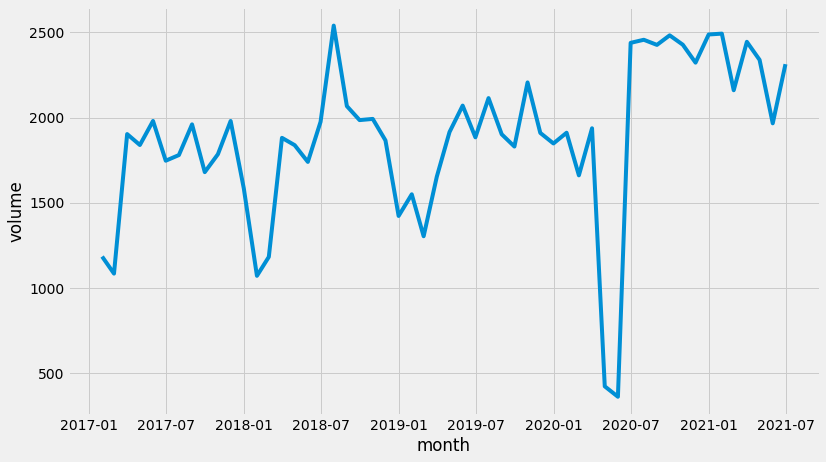

In [8]:
tempdf = df2.groupby('month')[['resale_price']].count()

plt.figure(figsize=(12,7))
sns.lineplot(y='resale_price', x=tempdf.index, data=tempdf)
plt.ylabel('volume')
#tempdf['resale_price'].plot(kind='line')
plt.show()

### Plot of total transaction volume over data period

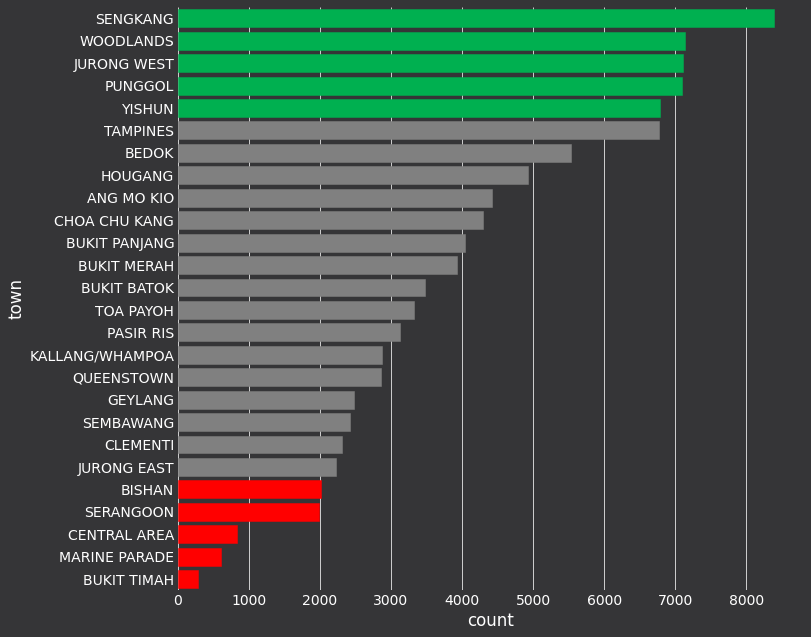

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
fig.patch.set_facecolor('#353537')
ax.set_facecolor('#353537')
#plt.grid(False)
#ax.spines["right"].set_visible(False)
#ax.spines["top"].set_visible(False)
[s.set_visible(False) for s in ax.spines.values()]
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

#sns.countplot(y='town', data=result_df, order=result_df['town'].value_counts().iloc[:10].index, color='skyblue')
sns.countplot(y='town', data=df2, order=df2['town'].value_counts().index, ax=ax)


for bar in ax.patches:
    if bar.get_width() > 6781:    # tampines is above 6781
        bar.set_color('#00B050')
    elif bar.get_width() < 2020:
        bar.set_color('red')
    else:
        bar.set_color('grey')
plt.show()

### Plot of housing supply by town

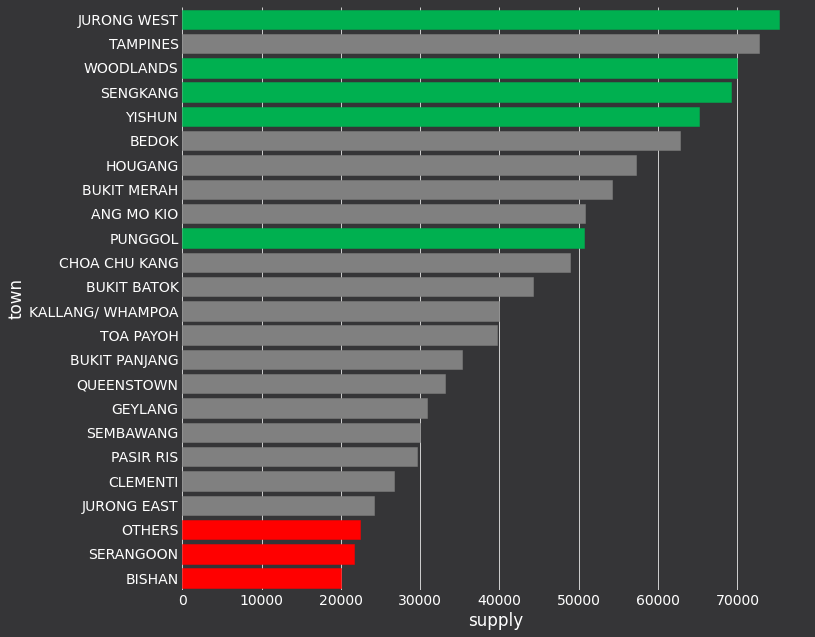

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
fig.patch.set_facecolor('#353537')
ax.set_facecolor('#353537')
#plt.grid(False)
#ax.spines["right"].set_visible(False)
#ax.spines["top"].set_visible(False)
[s.set_visible(False) for s in ax.spines.values()]
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

sns.barplot(y='town', x='supply', data=supply.sort_values(by='supply', ascending=False), ax=ax)

for bar in ax.patches:
    if bar.get_width() > 75000:
        bar.set_color('#00B050')   
    elif bar.get_width() > 65000 and bar.get_width() < 70000:
        bar.set_color('#00B050')           
    elif bar.get_width() == 50663:
        bar.set_color('#00B050')                   
    elif bar.get_width() < 23000:
        bar.set_color('red')
    else:
        bar.set_color('grey')
plt.show()

### plotting price distribution by town

In [141]:
sns.kdeplot(x='resale_price', data=df2, hue='town', \
            hue_order=df2['town'].value_counts().iloc[:5].index)
plt.ticklabel_format(style='plain', axis='both')

plt.show()

### Plotting total price distribution

In [107]:
resale_mean = df2['resale_price'].mean()
resale_std = df2['resale_price'].std()
sns.kdeplot(x='resale_price', data=df2)
plt.ticklabel_format(style='plain', axis='both')
plt.axvline(x=resale_mean, color='red', linestyle='--')
y = np.linspace(0, 0.0000033)
plt.fill_betweenx(y, resale_mean-resale_std, resale_mean+resale_std, alpha=0.2)

plt.show()

### Box plot of price by town

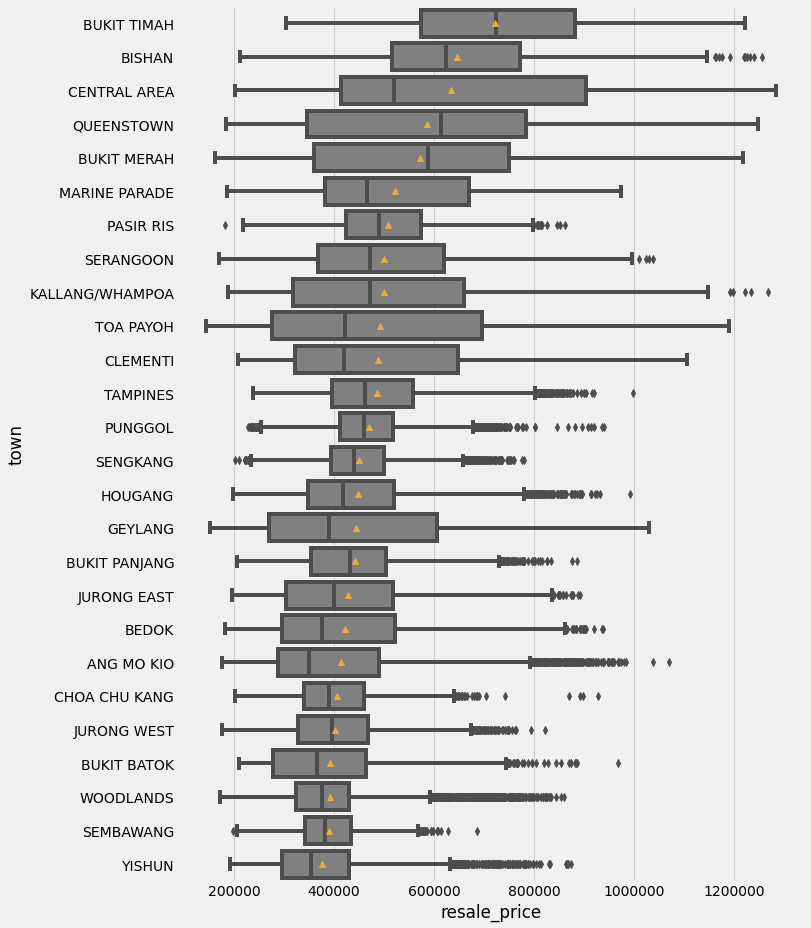

In [142]:
plt.figure(figsize=(10, 15))

sns.boxplot(x='resale_price', y='town', data=df2, color='grey', \
           order=df2.groupby('town')['resale_price'].mean().sort_values(ascending=False).index, \
           showmeans=True)
plt.ticklabel_format(style='plain', axis='x')

plt.show()

### Geospatial heatmap of transaction volume

In [109]:
import folium
#from folium import plugins
from folium.plugins import HeatMap

In [143]:
m = folium.Map(location=[1.3521, 103.8198], zoom_start=12)
heat_data = [[row['latitude'],row['longitude']] for index, row in df[['latitude', 'longitude']].iterrows()]
# Plot it on the map
HeatMap(heat_data).add_to(m)

# Display the map
m

### Price distribution by flat model

In [144]:
plt.figure(figsize=(10, 15))

sns.boxplot(x='resale_price', y='flat_model', data=df2, color='grey', \
           order=df2.groupby('flat_model')['resale_price'].mean().sort_values(ascending=False).index, \
           showmeans=True)
plt.ticklabel_format(style='plain', axis='x')

plt.show()

### Price distribution by storey range

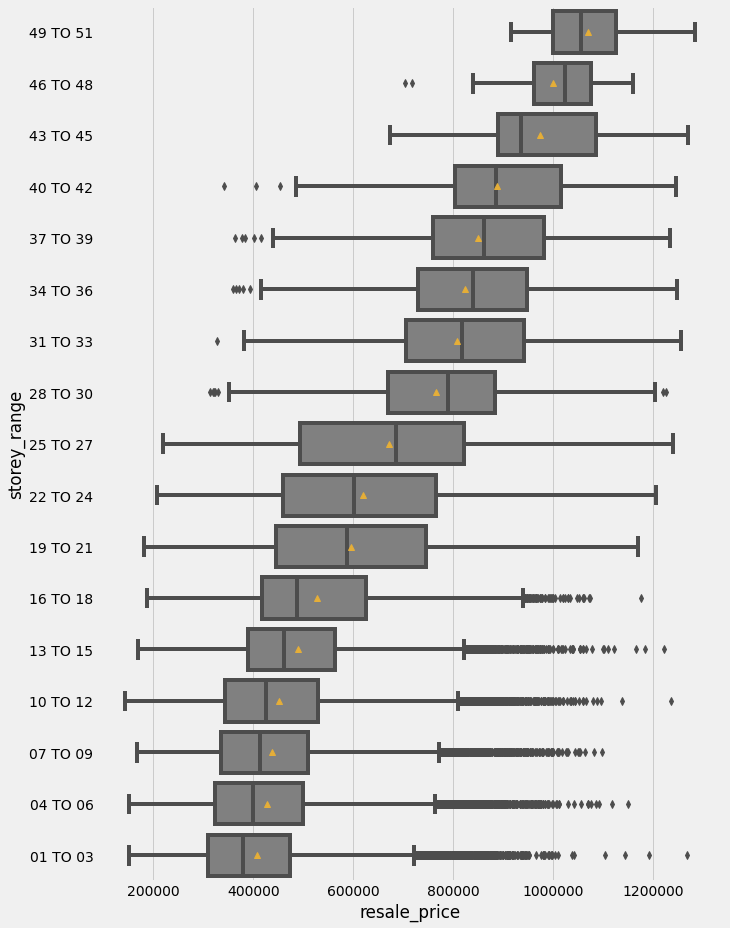

In [145]:
plt.figure(figsize=(10, 15))

sns.boxplot(x='resale_price', y='storey_range', data=df2, color='grey', \
           order=df2.groupby('storey_range')['resale_price'].mean().sort_values(ascending=False).index, \
           showmeans=True)
plt.ticklabel_format(style='plain', axis='x')

plt.show()

### Scatter plot of price and distance to station

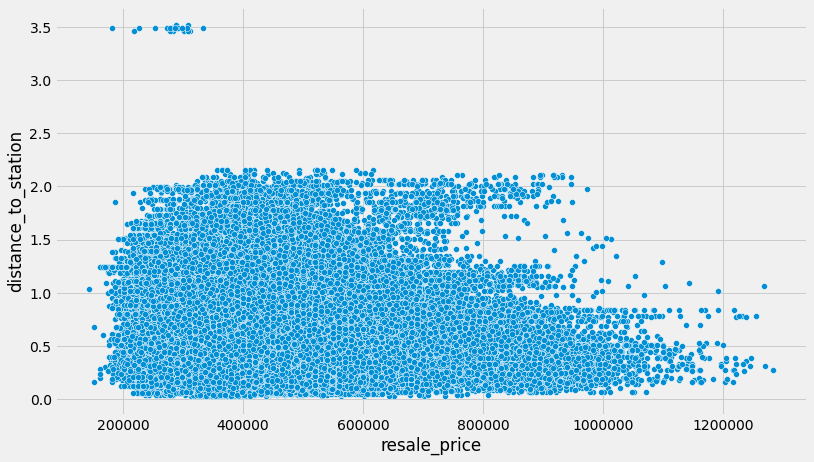

In [146]:
sns.scatterplot(x='resale_price', y='distance_to_station', data=df2)
plt.ticklabel_format(style='plain', axis='both')

plt.show()

### Plotting resale price over time and moving averages

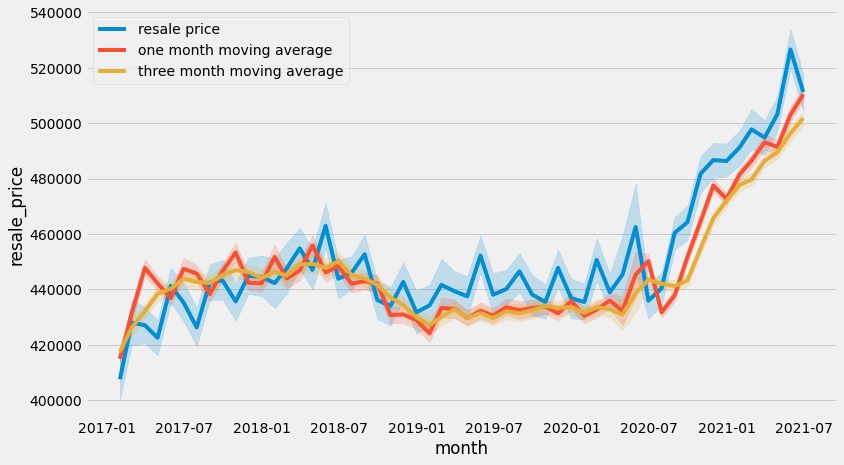

In [13]:
tempdf = df2.groupby(['month'])[['resale_price', 'one_month_mov_avg', \
                                       'three_month_mov_avg', 'new_supply_monthly']].mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))

sns.lineplot(x='month', y='resale_price', data=df2)
sns.lineplot(x='month', y='one_month_mov_avg', data=df2)
sns.lineplot(x='month', y='three_month_mov_avg', data=df2)

#ax1 = ax.twinx()
#sns.lineplot(data=tempdf['new_supply_monthly'], color='red', ax=ax1)

#tempdf2 = df2.groupby(['month'])[['resale_price']].count()
#sns.lineplot(y='resale_price', x=tempdf2.index, data=tempdf2, ax=ax1)
#ax1.set_ylabel('volume')

ax.grid(axis='x')
plt.legend(['resale price', 'one month moving average', 'three month moving average'])
#ax1.grid(False)

#sns.lineplot(x='month', y='one_month_mov_avg', data=tempdf, ax=ax)
#sns.lineplot(x='month', y='three_month_mov_avg', data=tempdf, ax=ax, color='green')
#sns.lineplot(x='month', y=['resale_price', 'one_month_mov_avg', 'three_month_mov_avg'], data=tempdf)
#tempdf
#plt.ticklabel_format(style='plain', axis='y')
plt.show()

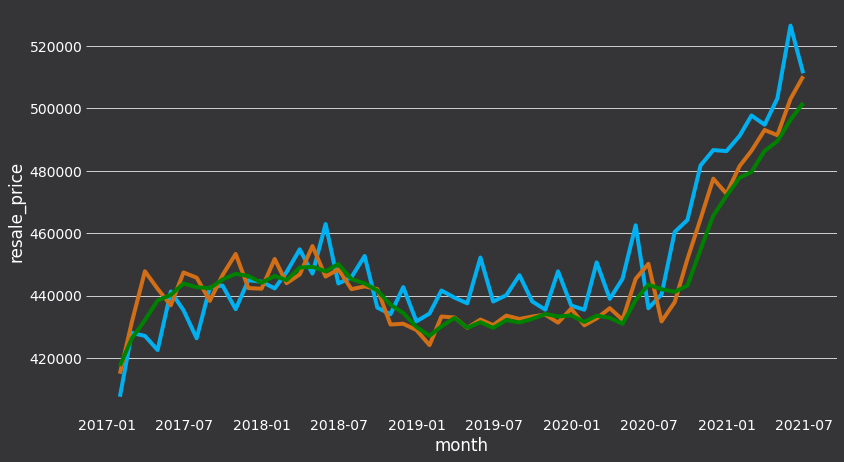

In [115]:
tempdf = df2.groupby(['month'])[['resale_price', 'one_month_mov_avg', \
                                       'three_month_mov_avg', 'new_supply_monthly']].mean()
#tempdf2 = df2.groupby(['month'])[['resale_price']].count()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))

fig.patch.set_facecolor('#353537')
ax.set_facecolor('#353537')
[s.set_visible(False) for s in ax.spines.values()]
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.grid(axis='x')

sns.lineplot(data=tempdf['resale_price'], color='#00B0F0', ax=ax)
sns.lineplot(data=tempdf['one_month_mov_avg'], color='#D26E16', ax=ax)
sns.lineplot(data=tempdf['three_month_mov_avg'], color='green', ax=ax)

#ax1 = ax.twinx()
#sns.lineplot(data=tempdf['new_supply_monthly'], color='orange', ax=ax1)
#sns.lineplot(y='resale_price', x=tempdf2.index, data=tempdf2, color='green', ax=ax1)
#ax1.set_ylabel('volume')

#ax1.set_facecolor('#353537')
#[s.set_visible(False) for s in ax1.spines.values()]
#ax1.tick_params(axis='both', colors='white')
#ax1.xaxis.label.set_color('white')
#ax1.yaxis.label.set_color('white')
#ax1.grid(False)

#sns.lineplot(x='month', y='one_month_mov_avg', data=tempdf, ax=ax)
#sns.lineplot(x='month', y='three_month_mov_avg', data=tempdf, ax=ax, color='green')
#sns.lineplot(x='month', y=['resale_price', 'one_month_mov_avg', 'three_month_mov_avg'], data=tempdf)
#tempdf
#plt.ticklabel_format(style='plain', axis='y')
plt.show()

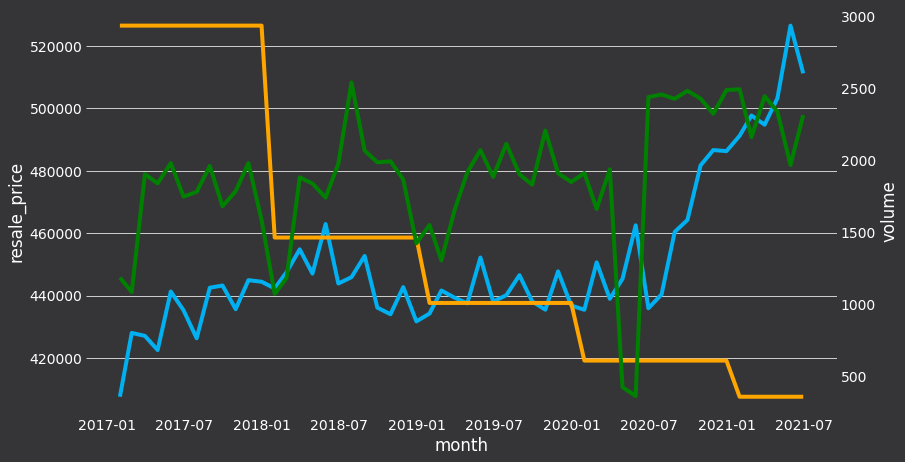

In [116]:
tempdf = df2.groupby(['month'])[['resale_price', 'one_month_mov_avg', \
                                       'three_month_mov_avg', 'new_supply_monthly']].mean()
tempdf2 = df2.groupby(['month'])[['resale_price']].count()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))

fig.patch.set_facecolor('#353537')
ax.set_facecolor('#353537')
[s.set_visible(False) for s in ax.spines.values()]
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.grid(axis='x')

sns.lineplot(data=tempdf['resale_price'], color='#00B0F0', ax=ax)
#sns.lineplot(data=tempdf['one_month_mov_avg'], color='#D26E16', ax=ax)
#sns.lineplot(data=tempdf['three_month_mov_avg'], color='green', ax=ax)

ax1 = ax.twinx()
sns.lineplot(data=tempdf['new_supply_monthly'], color='orange', ax=ax1)
sns.lineplot(y='resale_price', x=tempdf2.index, data=tempdf2, color='green', ax=ax1)
ax1.set_ylabel('volume')

ax1.set_facecolor('#353537')
[s.set_visible(False) for s in ax1.spines.values()]
ax1.tick_params(axis='both', colors='white')
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.grid(False)

#sns.lineplot(x='month', y='one_month_mov_avg', data=tempdf, ax=ax)
#sns.lineplot(x='month', y='three_month_mov_avg', data=tempdf, ax=ax, color='green')
#sns.lineplot(x='month', y=['resale_price', 'one_month_mov_avg', 'three_month_mov_avg'], data=tempdf)
#plt.ticklabel_format(style='plain', axis='y')
plt.show()

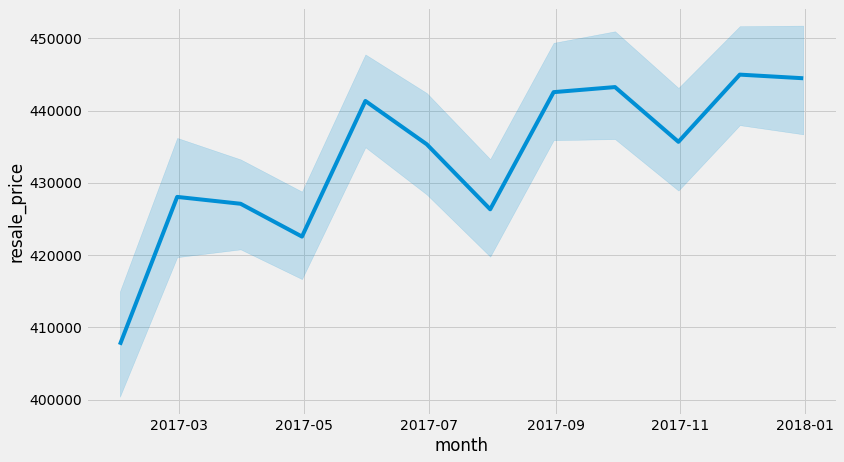

In [147]:
sns.lineplot(data=df2.set_index('month')['resale_price'].loc['2017'])
plt.show()

### distribution plots of numerical features

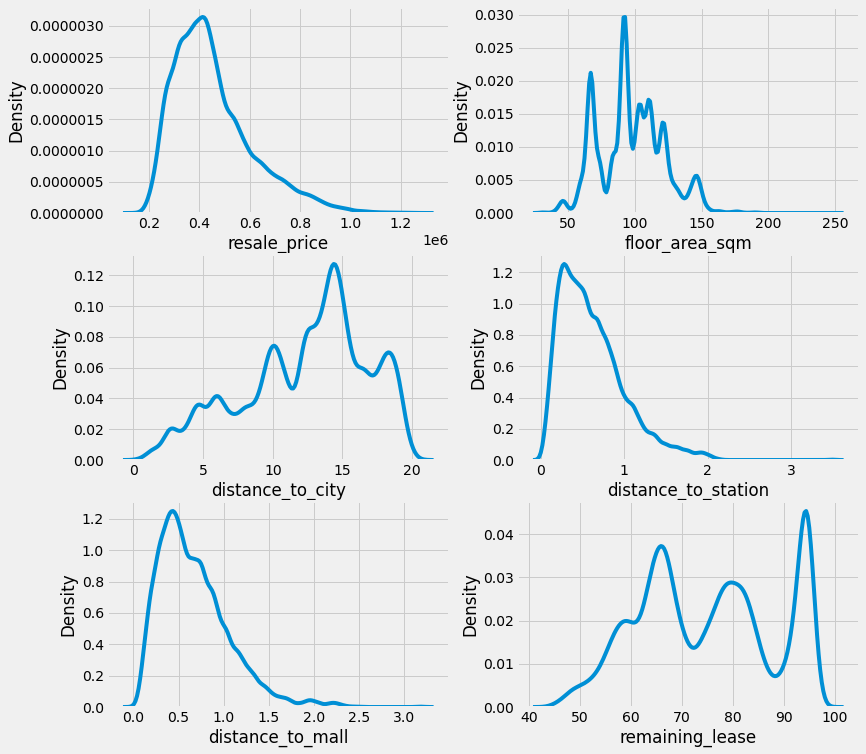

In [148]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
#fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,7))

sns.kdeplot(x='resale_price', data=df2, ax=ax1)
ax1.ticklabel_format(style='plain', axis='y')

sns.kdeplot(x='floor_area_sqm', data=df2, ax=ax2)
sns.kdeplot(x='distance_to_city', data=df2, ax=ax3)
sns.kdeplot(x='distance_to_station', data=df2, ax=ax4)
sns.kdeplot(x='distance_to_mall', data=df2, ax=ax5)
sns.kdeplot(x='remaining_lease', data=df2, ax=ax6)

#ax.ticklabel_format(style='plain', axis='x')
#plt.axvline(x=resale_mean, color='red', linestyle='--')
#y = np.linspace(0, 0.0000033)
#plt.fill_betweenx(y, resale_mean-resale_std, resale_mean+resale_std, alpha=0.2)

plt.show()

### countplot of flat types

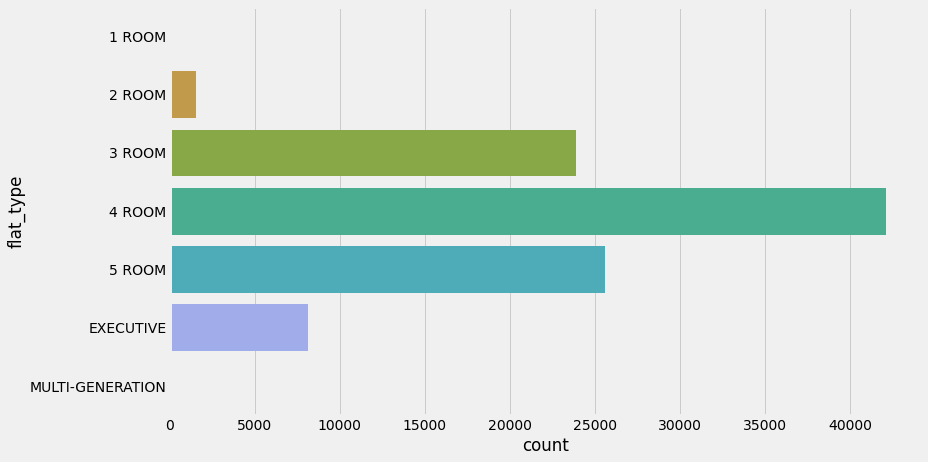

In [149]:
label = np.sort(df2['flat_type'].unique())

sns.countplot(y='flat_type', data=df2, order=label)
plt.show()

## count plot of storey range

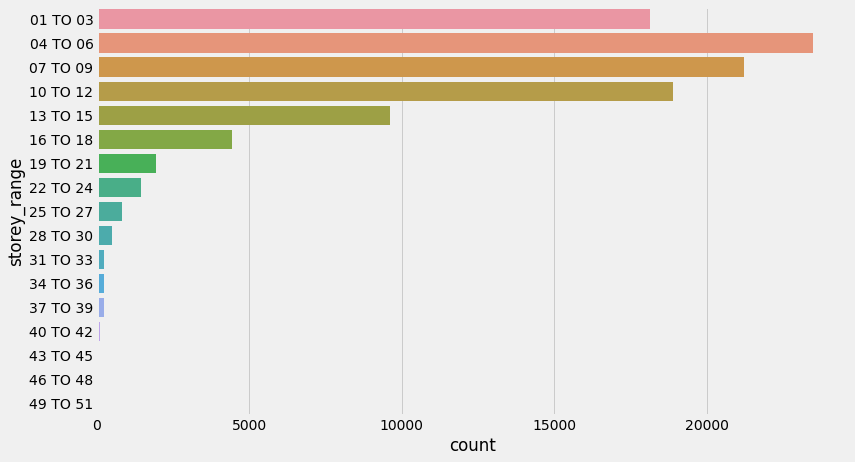

In [150]:
label = np.sort(df2['storey_range'].unique())

sns.countplot(y='storey_range', data=df2, order=label)
plt.show()

### count plot of flat models

In [121]:
plt.figure(figsize=(12,7))
sns.countplot(y='flat_model', data=df2, order=df2['flat_model'].value_counts().index)
plt.show()

In [151]:
df2.head()

month        town                address flat_type storey_range  \
0 2017-01-31  ANG MO KIO  406 ANG MO KIO AVE 10    2 ROOM     10 TO 12   
1 2017-01-31  ANG MO KIO   108 ANG MO KIO AVE 4    3 ROOM     01 TO 03   
2 2017-01-31  ANG MO KIO   602 ANG MO KIO AVE 5    3 ROOM     01 TO 03   
3 2017-01-31  ANG MO KIO  465 ANG MO KIO AVE 10    3 ROOM     04 TO 06   
4 2017-01-31  ANG MO KIO   601 ANG MO KIO AVE 5    3 ROOM     01 TO 03   

   floor_area_sqm      flat_model  remaining_lease  distance_to_city  \
0            44.0        Improved        61.333333          8.663925   
1            67.0  New Generation        60.583333          9.769367   
2            67.0  New Generation        62.416667         10.887571   
3            68.0  New Generation        62.083333          9.148658   
4            67.0  New Generation        62.416667         10.928380   

           nearest_station station_type  distance_to_station  \
0    Ang Mo Kio MRT (NS16)          MRT             1.003997   
1    Ang Mo Kio MRT (NS16)          MRT             1.292522   
2  Yio Chu Kang MRT (NS15)          MRT             1.071179   
3    Ang Mo Kio MRT (NS16)          MRT             0.945529   
4  Yio Chu Kang MRT (NS15)          MRT             1.094010   

                    nearest_mall  distance_to_mall  mature_estate  \
0                        AMK Hub          1.006212              1   
1                 Broadway Plaza          0.896029              1   
2                 Broadway Plaza          1.530164              1   
3  myVillage At Serangoon Garden          0.879263              1   
4                 Broadway Plaza          1.574032              1   

   new_supply_monthly  one_month_mov_avg  three_month_mov_avg  resale_price  
0                2934           417612.5        414888.598644      221000.0  
1                2934           417612.5        414888.598644      238000.0  
2                2934           417612.5        414888.598644      250000.0  
3                2934           417612.5        414888.598644      253000.0  
4                2934           417612.5        414888.598644      253000.0

### correlation heat map of numerical 

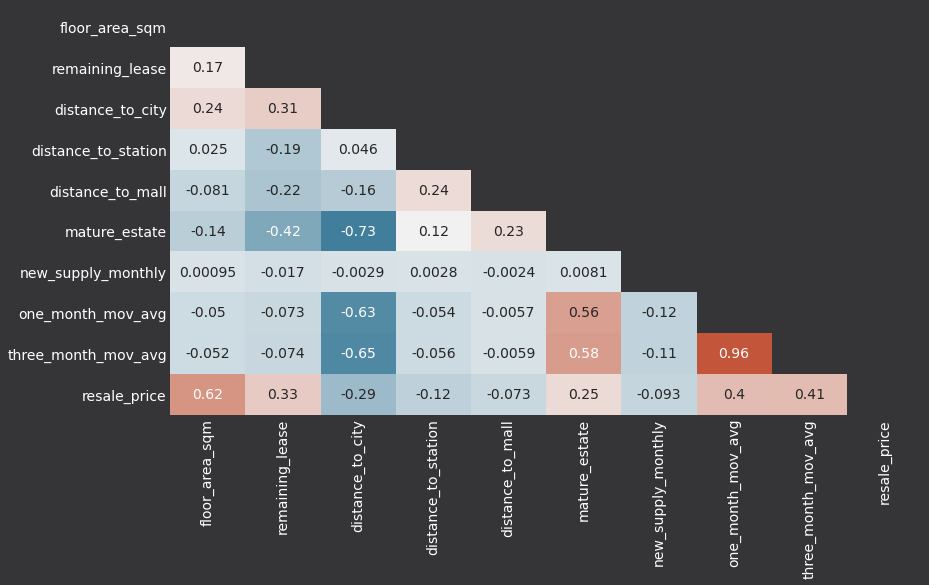

In [123]:
mask = np.triu(np.ones_like(df2.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(nrows=1, ncols=1)

fig.patch.set_facecolor('#353537')
ax.set_facecolor('#353537')
[s.set_visible(False) for s in ax.spines.values()]
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

sns.heatmap(df2.corr(), annot=True, fmt='.2g', cbar=False, mask=mask, cmap=cmap)
plt.show()

In [124]:
df2.corr()[['resale_price']].sort_values(by='resale_price', ascending=False)

resale_price
resale_price             1.000000
floor_area_sqm           0.624955
three_month_mov_avg      0.414371
one_month_mov_avg        0.402761
remaining_lease          0.334651
mature_estate            0.246497
distance_to_mall        -0.073084
new_supply_monthly      -0.093004
distance_to_station     -0.123845
distance_to_city        -0.290925

## Converting ordinal columns
Columns that can be convered to ordinal will be converted before saving in csv file

Columns: `flat_type`, `storey_range`, `station_type`

In [15]:
df3 = df2.copy()

In [16]:
df3.sample(3)

month             town                address flat_type  \
71653 2020-06-30      JURONG WEST  731 JURONG WEST ST 72    4 ROOM   
83488 2020-11-30         CLEMENTI     416 CLEMENTI AVE 1    5 ROOM   
7038  2017-05-31  KALLANG/WHAMPOA         7 BOON KENG RD    5 ROOM   

      storey_range  floor_area_sqm flat_model  remaining_lease  \
71653     01 TO 03           104.0    Model A        69.500000   
83488     37 TO 39           113.0   Improved        91.916667   
7038      31 TO 33           107.0       DBSS        92.666667   

       distance_to_city      nearest_station station_type  \
71653         18.297071   Pioneer MRT (EW28)          MRT   
83488          9.369905     Dover MRT (EW22)          MRT   
7038           3.808920  Boon Keng MRT (NE9)          MRT   

       distance_to_station             nearest_mall  distance_to_mall  \
71653             0.900276  Gek Poh Shopping Centre          0.358611   
83488             0.818216             321 Clementi          0.735310   
7038              0.284140                   Aperia          0.824913   

       mature_estate  new_supply_monthly  one_month_mov_avg  \
71653              0                 609      456209.777778   
83488              1                 609      540017.933333   
7038               1                2934      527518.276923   

       three_month_mov_avg  resale_price  
71653        428804.462102      303000.0  
83488        503387.162821      959000.0  
7038         501752.216941      943000.0

### converting `flat_type` to ordinal

In [17]:
df3['flat_type'].value_counts()

4 ROOM              42108
5 ROOM              25570
3 ROOM              23886
EXECUTIVE            8114
2 ROOM               1525
MULTI-GENERATION       52
1 ROOM                 48
Name: flat_type, dtype: int64

In [18]:
flat_type_dict = {'1 ROOM': 1, '2 ROOM':2, '3 ROOM':3, '4 ROOM':4, '5 ROOM':5, 
                  'EXECUTIVE':6, 'MULTI-GENERATION':7}
df3['flat_type'].replace(flat_type_dict, inplace=True)

In [19]:
# verifying
df3['flat_type'].value_counts()

4    42108
5    25570
3    23886
6     8114
2     1525
7       52
1       48
Name: flat_type, dtype: int64

### converting `storey_range` to ordinal

In [20]:
df3['storey_range'].value_counts()

04 TO 06    23485
07 TO 09    21211
10 TO 12    18910
01 TO 03    18135
13 TO 15     9615
16 TO 18     4445
19 TO 21     1927
22 TO 24     1429
25 TO 27      807
28 TO 30      488
31 TO 33      237
34 TO 36      231
37 TO 39      219
40 TO 42      108
43 TO 45       24
46 TO 48       23
49 TO 51        9
Name: storey_range, dtype: int64

In [21]:
# converting storey range to ordinal. multilply value by 3 to get upper limit of storey range
df3['storey_range_int'] = df3['storey_range'].str.split()
df3['storey_range_int'] = df3['storey_range_int'].apply(lambda x: x[-1])
df3['storey_range_int'] = df3['storey_range_int'].astype(int)

In [22]:
df3['storey_range'] = (df3['storey_range_int']/3).astype(int)
df3['storey_range'].value_counts()

2     23485
3     21211
4     18910
1     18135
5      9615
6      4445
7      1927
8      1429
9       807
10      488
11      237
12      231
13      219
14      108
15       24
16       23
17        9
Name: storey_range, dtype: int64

In [23]:
df3.drop(columns='storey_range_int', inplace=True)

### convert `station_type` to ordinal

In [24]:
df3['station_type'].replace({'LRT':0, 'MRT':1}, inplace=True)

## Correlation heatmap of numerical and ordinal features

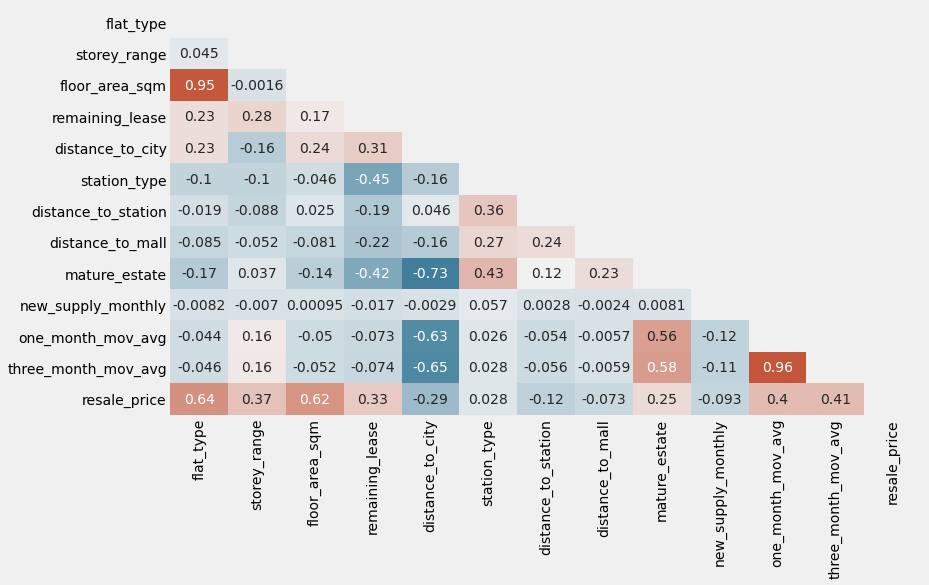

In [26]:
mask = np.triu(np.ones_like(df3.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(nrows=1, ncols=1)


sns.heatmap(df3.corr(), annot=True, fmt='.2g', cbar=False, mask=mask, cmap=cmap)
plt.show()

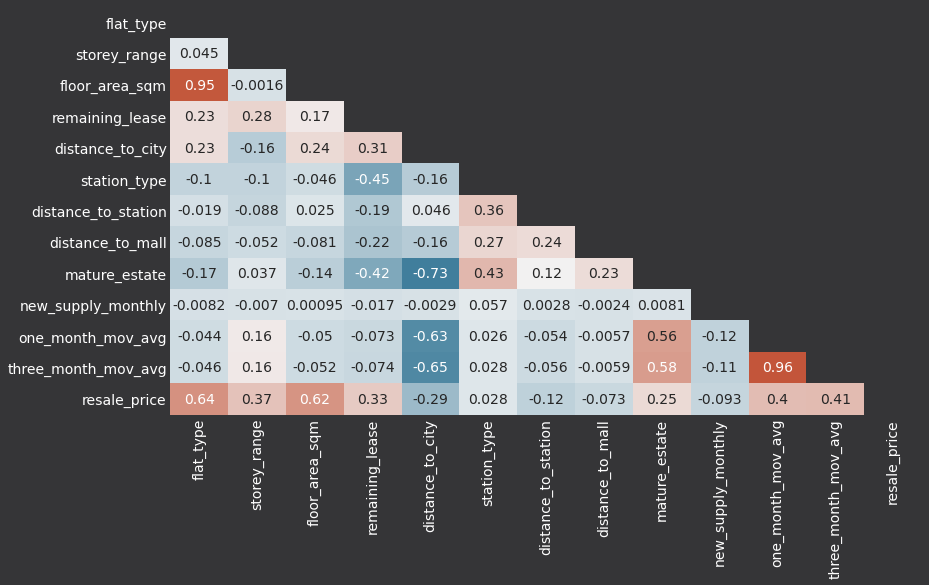

In [135]:
mask = np.triu(np.ones_like(df3.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(nrows=1, ncols=1)

fig.patch.set_facecolor('#353537')
ax.set_facecolor('#353537')
[s.set_visible(False) for s in ax.spines.values()]
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

sns.heatmap(df3.corr(), annot=True, fmt='.2g', cbar=False, mask=mask, cmap=cmap)
plt.show()

In [136]:
df3.corr()[['resale_price']].sort_values(by='resale_price', ascending=False)

resale_price
resale_price             1.000000
flat_type                0.637055
floor_area_sqm           0.624955
three_month_mov_avg      0.414371
one_month_mov_avg        0.402761
storey_range             0.370274
remaining_lease          0.334651
mature_estate            0.246497
station_type             0.027965
distance_to_mall        -0.073084
new_supply_monthly      -0.093004
distance_to_station     -0.123845
distance_to_city        -0.290925

## Preparing final dataset for modeling pipeline
We will discard the following features as we won't use them in our model.
`nearest_station`, `nearest_mall`

In [137]:
df3.set_index('month', inplace=True)

In [138]:
df3.sample(3)

town              address  flat_type  storey_range  \
month                                                                 
2018-02-28   TAMPINES   898 TAMPINES ST 81          3             1   
2021-02-28      BEDOK  519 BEDOK NTH AVE 1          3             4   
2020-10-31  TOA PAYOH    1 LOR 7 TOA PAYOH          3             3   

            floor_area_sqm      flat_model  remaining_lease  distance_to_city  \
month                                                                           
2018-02-28            74.0         Model A        69.166667         11.621384   
2021-02-28            67.0  New Generation        57.416667          9.976518   
2020-10-31            67.0        Improved        47.750000          6.153555   

                       nearest_station  station_type  distance_to_station  \
month                                                                       
2018-02-28    Tampines West MRT (DT31)             1             0.453769   
2021-02-28  Bedok Reservoir MRT (DT30)             1             0.788400   
2020-10-31         Braddell MRT (NS18)             1             0.747522   

                  nearest_mall  distance_to_mall  mature_estate  \
month                                                             
2018-02-28       Fairprice Hub          0.914086              1   
2021-02-28  Djitsun Mall Bedok          0.563111              1   
2020-10-31             HDB Hub          1.073490              1   

            new_supply_monthly  one_month_mov_avg  three_month_mov_avg  \
month                                                                    
2018-02-28                1463      498224.140351        487926.016014   
2021-02-28                 358      465501.086093        443621.571915   
2020-10-31                 609      437803.180723        420632.736387   

            resale_price  
month                     
2018-02-28      339000.0  
2021-02-28      313000.0  
2020-10-31      242000.0

In [139]:
df3.drop(columns=['nearest_station', 'nearest_mall'], inplace=True)

###### Checkpoint 3

In [140]:
df3.to_csv('capstone_dataset_final.csv')